

![image-20201226152702981](images/image-20201226152702981.png)


数据集State-of-the-Art详见

- [mnist](https://paperswithcode.com/sota/image-classification-on-mnist)
- [fashion-mnist](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)
- [cifar-10](https://paperswithcode.com/sota/image-classification-on-cifar-10)


## 获取数据

首先引入需要的包。

In [1]:
%%bash
 
# pip install -U ipyparams 
#pip install -U tensorflow_hub 
#pip install -U ipython
# pip install -U pymysql pyodbc
# pip install -U fasttext
pip install -U seaborn

In [2]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 

base_path = os.path.abspath('/tf/eipi10/jian-xu3/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# 设置GPU内存自动扩增
qtf.utils.set_gpu_memory_growth()

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

<IPython.core.display.Javascript object>

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.10) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
# 当module有新的方法的时候，需要运行下面方法。
%reload_ext autoreload

初始化参数。

In [4]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

data_generator = preprocessing.image.ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False) 

output_path = os.path.abspath('./output')
data_name = 'cifar10'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_image_count =  int(qbz95.utils.get_notebook_name().split('.')[0].split('_')[3])

params = {
    'data_name': data_name,
    'data_path': data_path,
    'train_image_count':train_image_count,
    'use_data_augmentation': False,
    'augmentation_generator': data_generator,       
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'batch_size': 32,    
    'epochs': 3,    
    'steps_per_epoch': int(train_image_count*10/32),
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':False,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },
    'model_params':{
        'mlp':{'dropout':0.1, 'layer_count':1, 'units':128, 'epochs':120},
        'lenet':{'dropout':0.2, 'epochs':120},
        'custom':{'dropout':0.2, 'epochs':120},
        'vgg':{'dropout':0.4, 'epochs':120},
        'resnet':{'epochs':80}        
    },
    'embedding_paths':{
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
# model_results.clear()

2022-08-10 11:06:11,134: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/results.json


### 下载数据

开始下载数据。

In [5]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

train_images = train_images/255.0   
test_images = test_images/255.0   

train_labels = np.squeeze(train_labels)
test_labels = np.squeeze(test_labels)

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)


(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


In [6]:
_, train_images, _, train_labels = train_test_split(train_images, train_labels, test_size=params.train_image_count*10, random_state=42)

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(5000, 32, 32, 3) (5000,)
(10000, 32, 32, 3) (10000,)


In [7]:
Counter(train_labels)

Counter({7: 509,
         8: 503,
         0: 476,
         6: 485,
         1: 487,
         5: 504,
         2: 527,
         4: 486,
         3: 523,
         9: 500})



### 查看数据

下面看一看实际的数据是啥样的。

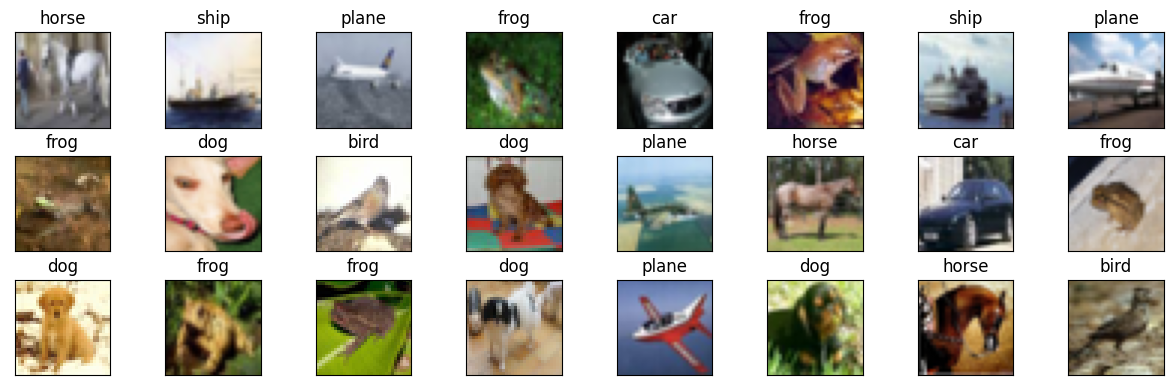

In [8]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### 类别分布

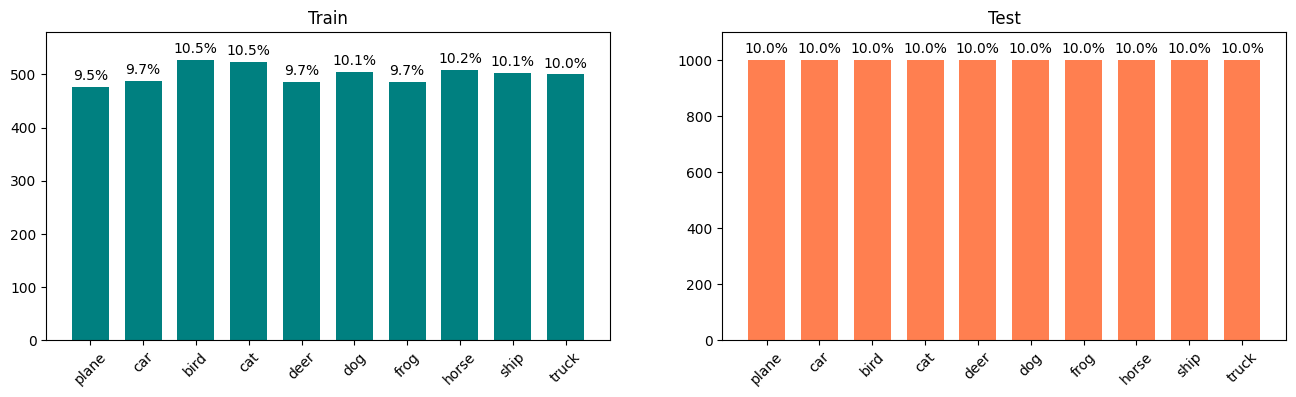

In [9]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



## 准备数据

不同的模型需要准备不同的数据，所以确定一下要构建哪种模型。

### 原始数据


In [10]:
raw_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, batch_size=params.batch_size)

In [11]:
sample_images, sample_labels = iter(raw_datasets.train_dataset).next()

In [12]:
raw_datasets.train_dataset.element_spec

(TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None),
 TensorSpec(shape=(32,), dtype=tf.uint8, name=None))

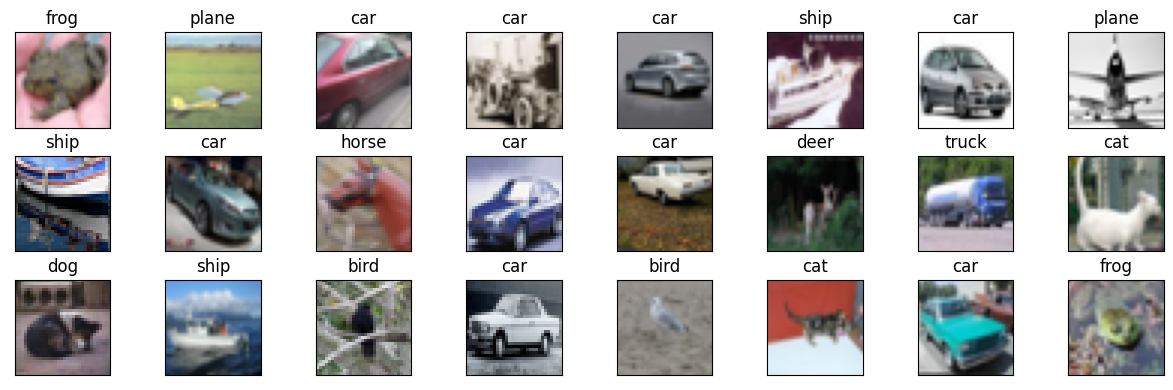

In [13]:
qtf.utils.show_images(sample_images, sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

In [21]:
tf.compat.v1.data.experimental.cardinality(raw_datasets.train_dataset)  

<tf.Tensor: shape=(), dtype=int64, numpy=156>

### 数据增强

In [14]:
data_generator.fit(train_images)
generator = {'train':qtf.classification.AugmentGenerator('augment', data_generator), 
             'val_test':qtf.classification.DatasetGenerator('val_test')}
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=False)

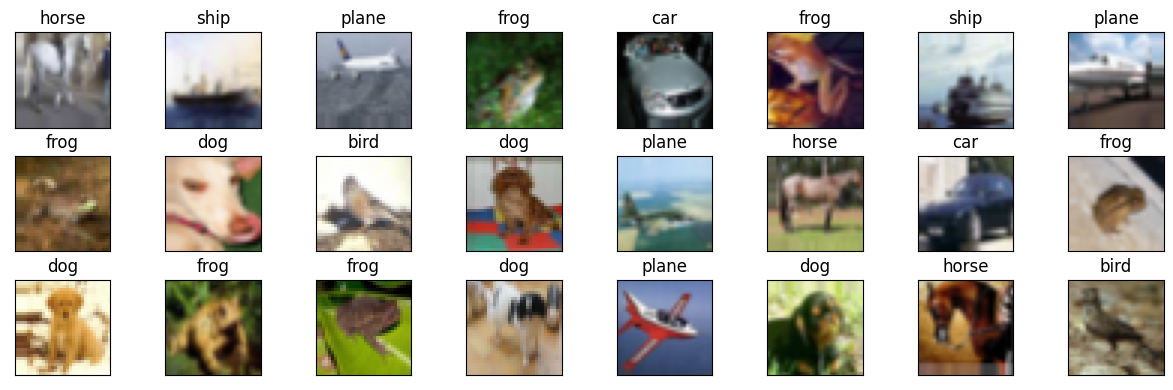

In [15]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

看看图片原始的样子

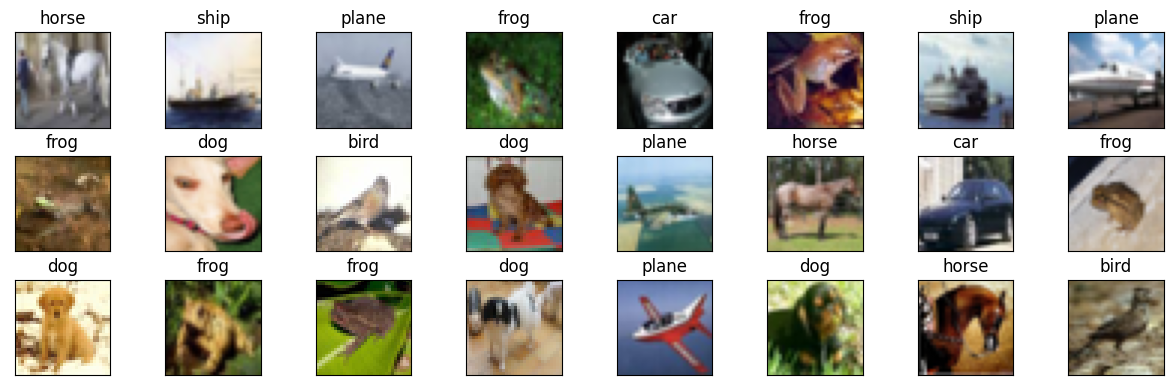

In [16]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

设置随机生成训练数据batch

In [17]:
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=True)

In [18]:
print(f'use_data_augmentation = {params.use_data_augmentation}')
if params.use_data_augmentation:
    datasets = augment_datasets
else:
    datasets = raw_datasets

use_data_augmentation = False


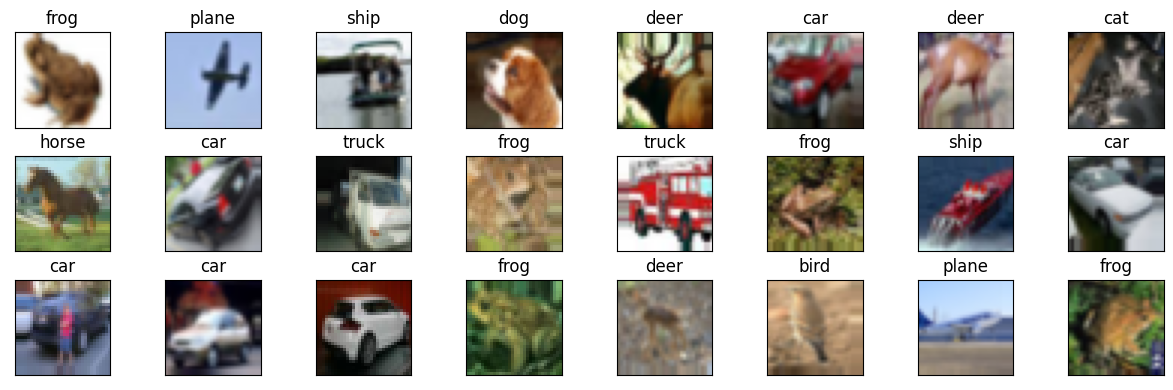

In [19]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 



##  模型

### MLP

2022-08-09 12:22:05,648: INFO: model_params.mlp1.dropout=0.1
2022-08-09 12:22:05,649: INFO: model_params.mlp1.layer_count=1
2022-08-09 12:22:05,649: INFO: model_params.mlp1.units=128
2022-08-09 12:22:05,688: INFO: learning_rate=0.001
2022-08-09 12:22:05,689: INFO: model_params.mlp1.clip_value=None
2022-08-09 12:22:05,698: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1


TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)
Model: "mlp1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 128)               393344    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
___________________________________________________________

2022-08-09 12:22:05,710: INFO: model_params.mlp1.epochs=120
2022-08-09 12:22:05,711: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1, monitor=val_accuracy)
2022-08-09 12:22:05,711: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-09 12:22:05,712: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-09 12:22:05,712: INFO: use LearningRateScheduler()
2022-08-09 12:22:05,713: INFO: steps_per_epoch=156
2022-08-09 12:22:05,714: INFO: start training
2022-08-09 12:22:05,714: INFO: use_class_weight=False


Epoch 1/120
138/156 [=========================>....] - ETA: 0s - loss: 2.2453 - accuracy: 0.1825INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1/assets


2022-08-09 12:22:08,344: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1/assets


156/156 [==============================] - 3s 12ms/step - loss: 2.2295 - accuracy: 0.1881 - val_loss: 2.0390 - val_accuracy: 0.2583 - lr: 0.0010
Epoch 2/120
155/156 [============================>.] - ETA: 0s - loss: 2.0379 - accuracy: 0.2565INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1/assets


2022-08-09 12:22:09,877: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1/assets


156/156 [==============================] - 2s 10ms/step - loss: 2.0388 - accuracy: 0.2564 - val_loss: 1.9469 - val_accuracy: 0.3001 - lr: 0.0010
Epoch 3/120
136/156 [=========================>....] - ETA: 0s - loss: 1.9705 - accuracy: 0.2787INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1/assets


2022-08-09 12:22:11,375: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1/assets


156/156 [==============================] - 1s 10ms/step - loss: 1.9699 - accuracy: 0.2760 - val_loss: 1.9235 - val_accuracy: 0.3090 - lr: 0.0010
Epoch 4/120
156/156 [==============================] - 1s 6ms/step - loss: 1.9337 - accuracy: 0.2841 - val_loss: 1.8993 - val_accuracy: 0.3016 - lr: 0.0010
Epoch 5/120
155/156 [============================>.] - ETA: 0s - loss: 1.9077 - accuracy: 0.2948INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1/assets


2022-08-09 12:22:13,889: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1/assets


156/156 [==============================] - 2s 10ms/step - loss: 1.9077 - accuracy: 0.2941 - val_loss: 1.8917 - val_accuracy: 0.3207 - lr: 0.0010
Epoch 6/120
156/156 [==============================] - ETA: 0s - loss: 1.8788 - accuracy: 0.3091INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1/assets


2022-08-09 12:22:15,466: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1/assets


156/156 [==============================] - 2s 10ms/step - loss: 1.8788 - accuracy: 0.3091 - val_loss: 1.8415 - val_accuracy: 0.3383 - lr: 0.0010
Epoch 7/120
156/156 [==============================] - 1s 6ms/step - loss: 1.8662 - accuracy: 0.3151 - val_loss: 1.8666 - val_accuracy: 0.3320 - lr: 0.0010
Epoch 8/120
135/156 [========================>.....] - ETA: 0s - loss: 1.8418 - accuracy: 0.3264INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1/assets


2022-08-09 12:22:18,170: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1/assets


156/156 [==============================] - 2s 11ms/step - loss: 1.8403 - accuracy: 0.3263 - val_loss: 1.8558 - val_accuracy: 0.3409 - lr: 0.0010
Epoch 9/120
156/156 [==============================] - 1s 6ms/step - loss: 1.8309 - accuracy: 0.3357 - val_loss: 1.8661 - val_accuracy: 0.3223 - lr: 0.0010
Epoch 10/120
156/156 [==============================] - 1s 6ms/step - loss: 1.8238 - accuracy: 0.3347 - val_loss: 1.8666 - val_accuracy: 0.3334 - lr: 0.0010
Epoch 11/120
156/156 [==============================] - 1s 6ms/step - loss: 1.8128 - accuracy: 0.3341 - val_loss: 1.8376 - val_accuracy: 0.3331 - lr: 0.0010
Epoch 12/120
156/156 [==============================] - 1s 6ms/step - loss: 1.7977 - accuracy: 0.3482 - val_loss: 1.8331 - val_accuracy: 0.3383 - lr: 0.0010
Epoch 13/120
155/156 [============================>.] - ETA: 0s - loss: 1.7793 - accuracy: 0.3486INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/c

2022-08-09 12:22:23,428: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1/assets


156/156 [==============================] - 2s 10ms/step - loss: 1.7805 - accuracy: 0.3484 - val_loss: 1.8165 - val_accuracy: 0.3514 - lr: 0.0010
Epoch 14/120
156/156 [==============================] - 1s 6ms/step - loss: 1.7675 - accuracy: 0.3526 - val_loss: 1.8461 - val_accuracy: 0.3354 - lr: 0.0010
Epoch 15/120
156/156 [==============================] - 1s 6ms/step - loss: 1.7636 - accuracy: 0.3568 - val_loss: 1.8204 - val_accuracy: 0.3506 - lr: 0.0010
Epoch 16/120
156/156 [==============================] - 1s 6ms/step - loss: 1.7550 - accuracy: 0.3634 - val_loss: 1.8304 - val_accuracy: 0.3448 - lr: 0.0010
Epoch 17/120
156/156 [==============================] - 1s 6ms/step - loss: 1.7502 - accuracy: 0.3578 - val_loss: 1.8197 - val_accuracy: 0.3501 - lr: 0.0010
Epoch 18/120
156/156 [==============================] - 1s 6ms/step - loss: 1.7401 - accuracy: 0.3596 - val_loss: 1.8217 - val_accuracy: 0.3503 - lr: 0.0010
Epoch 19/120
156/156 [==============================] - 1s 6ms/step - 

2022-08-09 12:22:30,597: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1/assets


156/156 [==============================] - 2s 10ms/step - loss: 1.7244 - accuracy: 0.3762 - val_loss: 1.8142 - val_accuracy: 0.3547 - lr: 0.0010
Epoch 21/120
156/156 [==============================] - 1s 6ms/step - loss: 1.7282 - accuracy: 0.3682 - val_loss: 1.8452 - val_accuracy: 0.3441 - lr: 0.0010
Epoch 22/120
156/156 [==============================] - 1s 6ms/step - loss: 1.7215 - accuracy: 0.3790 - val_loss: 1.8267 - val_accuracy: 0.3501 - lr: 0.0010
Epoch 23/120
156/156 [==============================] - 1s 6ms/step - loss: 1.7149 - accuracy: 0.3774 - val_loss: 1.8336 - val_accuracy: 0.3439 - lr: 0.0010
Epoch 24/120
156/156 [==============================] - 1s 6ms/step - loss: 1.7105 - accuracy: 0.3756 - val_loss: 1.8397 - val_accuracy: 0.3407 - lr: 0.0010
Epoch 25/120
156/156 [==============================] - 1s 6ms/step - loss: 1.6981 - accuracy: 0.3786 - val_loss: 1.8233 - val_accuracy: 0.3526 - lr: 0.0010
Epoch 26/120
156/156 [==============================] - 1s 6ms/step - 

2022-08-09 12:22:39,745: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1/assets


156/156 [==============================] - 2s 10ms/step - loss: 1.6677 - accuracy: 0.3998 - val_loss: 1.8024 - val_accuracy: 0.3620 - lr: 0.0010
Epoch 30/120
156/156 [==============================] - 1s 6ms/step - loss: 1.6809 - accuracy: 0.4000 - val_loss: 1.8086 - val_accuracy: 0.3591 - lr: 0.0010
Epoch 31/120
156/156 [==============================] - 1s 6ms/step - loss: 1.6675 - accuracy: 0.3952 - val_loss: 1.8320 - val_accuracy: 0.3512 - lr: 0.0010
Epoch 32/120
156/156 [==============================] - 1s 6ms/step - loss: 1.6595 - accuracy: 0.3958 - val_loss: 1.8507 - val_accuracy: 0.3484 - lr: 0.0010
Epoch 33/120
150/156 [===========================>..] - ETA: 0s - loss: 1.6595 - accuracy: 0.3965INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1/assets


2022-08-09 12:22:44,123: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1/assets


156/156 [==============================] - 2s 10ms/step - loss: 1.6602 - accuracy: 0.3962 - val_loss: 1.8152 - val_accuracy: 0.3635 - lr: 0.0010
Epoch 34/120
156/156 [==============================] - 1s 6ms/step - loss: 1.6521 - accuracy: 0.4073 - val_loss: 1.8254 - val_accuracy: 0.3524 - lr: 0.0010
Epoch 35/120
156/156 [==============================] - 1s 6ms/step - loss: 1.6522 - accuracy: 0.3988 - val_loss: 1.8439 - val_accuracy: 0.3499 - lr: 0.0010
Epoch 36/120
156/156 [==============================] - 1s 6ms/step - loss: 1.6563 - accuracy: 0.3970 - val_loss: 1.8245 - val_accuracy: 0.3611 - lr: 0.0010
Epoch 37/120
156/156 [==============================] - 1s 6ms/step - loss: 1.6382 - accuracy: 0.4149 - val_loss: 1.8580 - val_accuracy: 0.3496 - lr: 0.0010
Epoch 38/120
156/156 [==============================] - 1s 6ms/step - loss: 1.6236 - accuracy: 0.4169 - val_loss: 1.8433 - val_accuracy: 0.3601 - lr: 0.0010
Epoch 39/120
156/156 [==============================] - 1s 6ms/step - 

2022-08-09 12:22:56,210: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1/assets


156/156 [==============================] - 2s 10ms/step - loss: 1.5699 - accuracy: 0.4313 - val_loss: 1.8059 - val_accuracy: 0.3662 - lr: 3.1623e-04
Epoch 00046: Still keep learning rate 0.0003162 instead of 0.001
Epoch 46/120
156/156 [==============================] - 1s 6ms/step - loss: 1.5560 - accuracy: 0.4417 - val_loss: 1.8064 - val_accuracy: 0.3621 - lr: 3.1623e-04
Epoch 00047: Still keep learning rate 0.0003162 instead of 0.001
Epoch 47/120
154/156 [============================>.] - ETA: 0s - loss: 1.5584 - accuracy: 0.4383INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1/assets


2022-08-09 12:22:58,767: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1/assets


156/156 [==============================] - 2s 10ms/step - loss: 1.5580 - accuracy: 0.4387 - val_loss: 1.8043 - val_accuracy: 0.3670 - lr: 3.1623e-04
Epoch 00048: Still keep learning rate 0.0003162 instead of 0.001
Epoch 48/120
156/156 [==============================] - 1s 6ms/step - loss: 1.5392 - accuracy: 0.4363 - val_loss: 1.8054 - val_accuracy: 0.3648 - lr: 3.1623e-04
Epoch 00049: Still keep learning rate 0.0003162 instead of 0.001
Epoch 49/120
156/156 [==============================] - ETA: 0s - loss: 1.5508 - accuracy: 0.4397INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1/assets


2022-08-09 12:23:01,296: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1/assets


156/156 [==============================] - 2s 10ms/step - loss: 1.5508 - accuracy: 0.4397 - val_loss: 1.8095 - val_accuracy: 0.3678 - lr: 3.1623e-04
Epoch 00050: Still keep learning rate 0.0003162 instead of 0.001
Epoch 50/120
156/156 [==============================] - 1s 6ms/step - loss: 1.5441 - accuracy: 0.4391 - val_loss: 1.8218 - val_accuracy: 0.3628 - lr: 3.1623e-04
Epoch 00051: Still keep learning rate 0.0003162 instead of 0.001
Epoch 51/120
156/156 [==============================] - 1s 6ms/step - loss: 1.5410 - accuracy: 0.4385 - val_loss: 1.8125 - val_accuracy: 0.3668 - lr: 3.1623e-04
Epoch 00052: Still keep learning rate 0.0003162 instead of 0.001
Epoch 52/120
156/156 [==============================] - 1s 6ms/step - loss: 1.5372 - accuracy: 0.4459 - val_loss: 1.8106 - val_accuracy: 0.3665 - lr: 3.1623e-04
Epoch 00053: Still keep learning rate 0.0003162 instead of 0.001
Epoch 53/120
156/156 [==============================] - 1s 6ms/step - loss: 1.5325 - accuracy: 0.4469 - val_

2022-08-09 12:23:12,231: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1/assets


156/156 [==============================] - 2s 10ms/step - loss: 1.5133 - accuracy: 0.4509 - val_loss: 1.8140 - val_accuracy: 0.3679 - lr: 1.0000e-04
Epoch 61/120
156/156 [==============================] - 1s 6ms/step - loss: 1.5082 - accuracy: 0.4491 - val_loss: 1.8116 - val_accuracy: 0.3674 - lr: 1.0000e-04
Epoch 62/120
137/156 [=========================>....] - ETA: 0s - loss: 1.5187 - accuracy: 0.4489INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1/assets


2022-08-09 12:23:14,724: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1/assets


156/156 [==============================] - 2s 10ms/step - loss: 1.5151 - accuracy: 0.4513 - val_loss: 1.8120 - val_accuracy: 0.3699 - lr: 1.0000e-04
Epoch 63/120
156/156 [==============================] - 1s 6ms/step - loss: 1.5003 - accuracy: 0.4551 - val_loss: 1.8151 - val_accuracy: 0.3674 - lr: 1.0000e-04
Epoch 64/120
156/156 [==============================] - 1s 6ms/step - loss: 1.4983 - accuracy: 0.4527 - val_loss: 1.8137 - val_accuracy: 0.3686 - lr: 1.0000e-04
Epoch 65/120
156/156 [==============================] - 1s 6ms/step - loss: 1.4995 - accuracy: 0.4509 - val_loss: 1.8148 - val_accuracy: 0.3662 - lr: 1.0000e-04
Epoch 66/120
156/156 [==============================] - 1s 6ms/step - loss: 1.4983 - accuracy: 0.4565 - val_loss: 1.8147 - val_accuracy: 0.3674 - lr: 1.0000e-04
Epoch 67/120
156/156 [==============================] - 1s 6ms/step - loss: 1.4987 - accuracy: 0.4523 - val_loss: 1.8164 - val_accuracy: 0.3697 - lr: 1.0000e-04
Epoch 68/120
156/156 [========================

2022-08-09 12:23:24,343: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1/assets


156/156 [==============================] - 2s 12ms/step - loss: 1.5070 - accuracy: 0.4593 - val_loss: 1.8148 - val_accuracy: 0.3701 - lr: 1.0000e-04
Epoch 72/120
156/156 [==============================] - 1s 6ms/step - loss: 1.5020 - accuracy: 0.4527 - val_loss: 1.8168 - val_accuracy: 0.3676 - lr: 1.0000e-04
Epoch 73/120
156/156 [==============================] - 1s 6ms/step - loss: 1.4973 - accuracy: 0.4599 - val_loss: 1.8172 - val_accuracy: 0.3698 - lr: 1.0000e-04
Epoch 74/120
135/156 [========================>.....] - ETA: 0s - loss: 1.5042 - accuracy: 0.4495
Epoch 74: ReduceLROnPlateau reducing learning rate to 3.1622775802825264e-05.
156/156 [==============================] - 1s 6ms/step - loss: 1.4985 - accuracy: 0.4553 - val_loss: 1.8171 - val_accuracy: 0.3699 - lr: 3.1623e-05
Epoch 00075: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 75/120
139/156 [=========================>....] - ETA: 0s - loss: 1.4881 - accuracy: 0.4643INFO:tensorflow:Assets written to: /tf/eipi

2022-08-09 12:23:28,815: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1/assets


156/156 [==============================] - 2s 10ms/step - loss: 1.4858 - accuracy: 0.4673 - val_loss: 1.8134 - val_accuracy: 0.3711 - lr: 3.1623e-05
Epoch 00076: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 76/120
139/156 [=========================>....] - ETA: 0s - loss: 1.4934 - accuracy: 0.4526INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1/assets


2022-08-09 12:23:30,416: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1/assets


156/156 [==============================] - 2s 10ms/step - loss: 1.4923 - accuracy: 0.4543 - val_loss: 1.8142 - val_accuracy: 0.3715 - lr: 3.1623e-05
Epoch 00077: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 77/120
156/156 [==============================] - 1s 6ms/step - loss: 1.4833 - accuracy: 0.4555 - val_loss: 1.8143 - val_accuracy: 0.3707 - lr: 3.1623e-05
Epoch 00078: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 78/120
156/156 [==============================] - 1s 6ms/step - loss: 1.4901 - accuracy: 0.4609 - val_loss: 1.8136 - val_accuracy: 0.3711 - lr: 3.1623e-05
Epoch 00079: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 79/120
153/156 [============================>.] - ETA: 0s - loss: 1.4864 - accuracy: 0.4614INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1/assets


2022-08-09 12:23:34,008: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1/assets


156/156 [==============================] - 2s 11ms/step - loss: 1.4858 - accuracy: 0.4613 - val_loss: 1.8132 - val_accuracy: 0.3726 - lr: 3.1623e-05
Epoch 00080: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 80/120
156/156 [==============================] - 1s 6ms/step - loss: 1.4838 - accuracy: 0.4595 - val_loss: 1.8137 - val_accuracy: 0.3713 - lr: 3.1623e-05
Epoch 00081: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 81/120
156/156 [==============================] - 1s 6ms/step - loss: 1.4944 - accuracy: 0.4565 - val_loss: 1.8125 - val_accuracy: 0.3719 - lr: 3.1623e-05
Epoch 00082: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 82/120
156/156 [==============================] - 1s 6ms/step - loss: 1.4872 - accuracy: 0.4621 - val_loss: 1.8142 - val_accuracy: 0.3713 - lr: 3.1623e-05
Epoch 00083: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 83/120
156/156 [==============================] - 1s 6ms/step - loss: 1.4775 - accuracy: 0.4611 - val_

2022-08-09 12:23:44,401: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1/assets



Epoch 89: ReduceLROnPlateau reducing learning rate to 9.999999259090306e-06.
156/156 [==============================] - 2s 11ms/step - loss: 1.4739 - accuracy: 0.4692 - val_loss: 1.8163 - val_accuracy: 0.3729 - lr: 1.0000e-05
Epoch 00090: Still keep learning rate 1e-05 instead of 0.0001
Epoch 90/120
156/156 [==============================] - 1s 6ms/step - loss: 1.4833 - accuracy: 0.4595 - val_loss: 1.8140 - val_accuracy: 0.3703 - lr: 1.0000e-05
Epoch 91/120
156/156 [==============================] - 1s 6ms/step - loss: 1.4760 - accuracy: 0.4643 - val_loss: 1.8141 - val_accuracy: 0.3695 - lr: 1.0000e-05
Epoch 92/120
156/156 [==============================] - 1s 6ms/step - loss: 1.4776 - accuracy: 0.4605 - val_loss: 1.8130 - val_accuracy: 0.3711 - lr: 1.0000e-05
Epoch 93/120
156/156 [==============================] - 1s 6ms/step - loss: 1.4782 - accuracy: 0.4639 - val_loss: 1.8131 - val_accuracy: 0.3698 - lr: 1.0000e-05
Epoch 94/120
156/156 [==============================] - 1s 6ms/step

2022-08-09 12:24:14,190: INFO: finish training [elapsed time: 128.48 seconds]


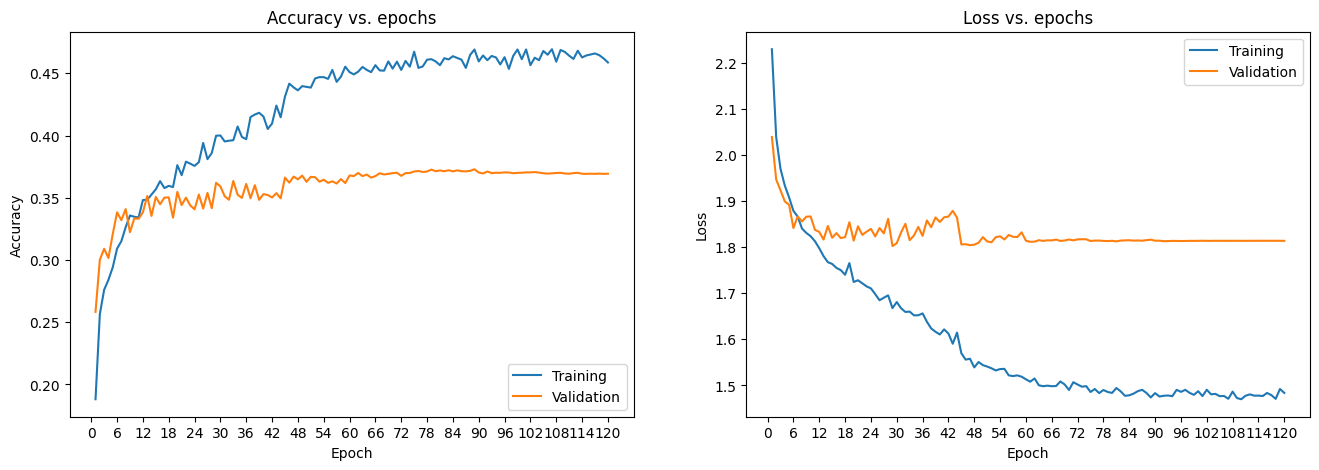

2022-08-09 12:24:14,699: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 1ms/step


2022-08-09 12:24:19,461: INFO: test loss:1.8163
2022-08-09 12:24:19,462: INFO: test accuracy:0.3729
2022-08-09 12:24:19,463: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/results.json
2022-08-09 12:24:19,465: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/results.json
2022-08-09 12:24:19,465: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/default.generator
2022-08-09 12:24:19,466: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/default.generator
2022-08-09 12:24:19,467: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/le

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-09 12:24:20,320: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/default.generator


313/313 [==============================] - 2s 2ms/step


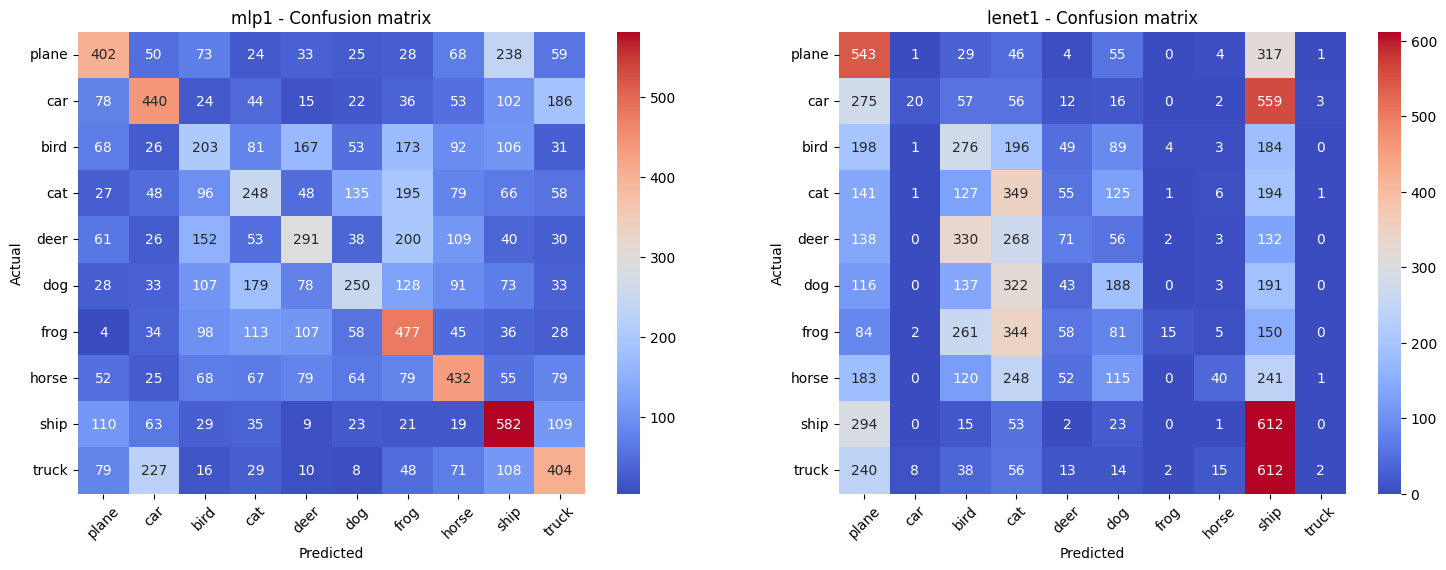

2022-08-09 12:24:25,736: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1


----------------------------------------sample analysis----------------------------------------


2022-08-09 12:24:26,590: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/default.generator
2022-08-09 12:24:26,594: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20
2022-08-09 12:24:31,364: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/default.generator
2022-08-09 12:24:31,377: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1
2022-08-09 12:24:32,311: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/default.generator
2022-08-09 12:24:32,315: INFO: loading model from /tf/eipi10/xuxiangwen.g

1/1 [==============================] - 0s 144ms/step


2022-08-09 12:24:36,924: WARNING: 5 out of the last 631 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f94c420b280> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 10ms/step


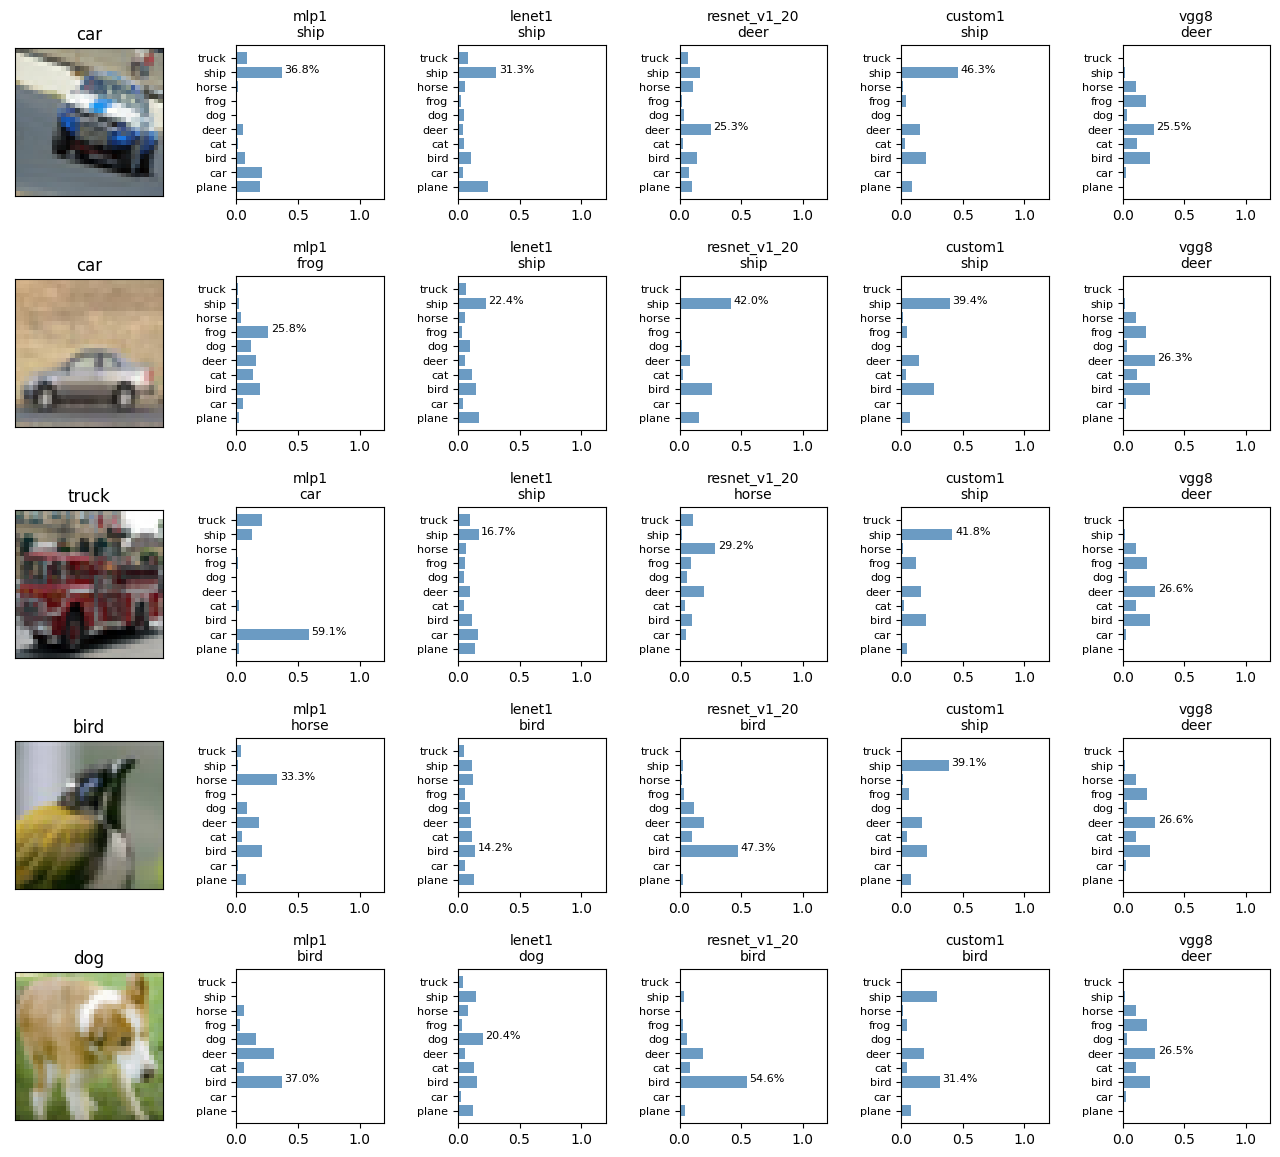

----------------------------------------models----------------------------------------


model_name                  program_name  weight_number  train_time  \
1          mlp1  cifar10_0808_count_500.ipynb         394634       128.5   
2        lenet1  cifar10_0808_count_500.ipynb          83170         4.2   
3  resnet_v1_20  cifar10_0808_count_500.ipynb         273066        18.6   
4       custom1  cifar10_0808_count_500.ipynb          73738         5.0   
5          vgg8  cifar10_0808_count_500.ipynb        1672906         8.9   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-09 12:24      1.3852     1.8163          0.5162         0.3729   
2  2022-08-09 12:15      2.1346     2.1539          0.2218         0.2116   
3  2022-08-09 12:18      2.3461     2.3815          0.2062         0.1980   
4  2022-08-09 12:16      3.2211     3.2277          0.1230         0.1216   
5  2022-08-09 12:17      2.9014     2.9135          0.0972         0.1000   

   train_auc  test_auc  
1     0.8894    0.8013  
2     0.7561    0.7500  
3     0.7818    0.7750  
4     0.7088    0.7067  
5     0.6073    0.6134

In [20]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.mlp1(helper, name='mlp1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 




从上面的错误来看，模型对一些细节的判断不是很准。下面来尝试一下LeNet。

### LeNet

![image-20201019113632136](images/image-20201019113632136.png)

LeNet诞生于1994年，是Yann LeCun等人提出的，是最早的卷积神经网络之一。在LeNet中，输入层是32×32的图片，而MNIST是28×28的图片，为了保持模型的结构不变，在第一个Conv2D设置参数padding=’same’。首先创建模型，并训练。

2022-08-09 12:24:40,906: INFO: model_params.lenet1.dropout=0.2
2022-08-09 12:24:40,997: INFO: learning_rate=0.001
2022-08-09 12:24:40,998: INFO: model_params.lenet1.clip_value=None
2022-08-09 12:24:41,005: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1


TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)
Model: "lenet1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 6)         456       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 6)        24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 6)        0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 6)         0         
                                                               

2022-08-09 12:24:41,031: INFO: model_params.lenet1.epochs=120
2022-08-09 12:24:41,031: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1, monitor=val_accuracy)
2022-08-09 12:24:41,032: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-09 12:24:41,033: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-09 12:24:41,033: INFO: use LearningRateScheduler()
2022-08-09 12:24:41,034: INFO: steps_per_epoch=156
2022-08-09 12:24:41,034: INFO: start training
2022-08-09 12:24:41,035: INFO: use_class_weight=False


Epoch 1/120
147/156 [===========================>..] - ETA: 0s - loss: 2.2295 - accuracy: 0.2090

2022-08-09 12:24:45,540: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


2022-08-09 12:24:46,142: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


156/156 [==============================] - 5s 27ms/step - loss: 2.2180 - accuracy: 0.2125 - val_loss: 2.1097 - val_accuracy: 0.2015 - lr: 0.0010
Epoch 2/120
156/156 [==============================] - ETA: 0s - loss: 1.9342 - accuracy: 0.3001

2022-08-09 12:24:49,148: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


2022-08-09 12:24:49,737: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


156/156 [==============================] - 4s 23ms/step - loss: 1.9342 - accuracy: 0.3001 - val_loss: 1.9039 - val_accuracy: 0.3029 - lr: 0.0010
Epoch 3/120
149/156 [===========================>..] - ETA: 0s - loss: 1.7967 - accuracy: 0.3530

2022-08-09 12:24:52,961: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


2022-08-09 12:24:53,531: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


156/156 [==============================] - 4s 24ms/step - loss: 1.7928 - accuracy: 0.3540 - val_loss: 1.7387 - val_accuracy: 0.3552 - lr: 0.0010
Epoch 4/120
145/156 [==========================>...] - ETA: 0s - loss: 1.7136 - accuracy: 0.3750

2022-08-09 12:24:56,240: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


2022-08-09 12:24:56,833: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


156/156 [==============================] - 3s 21ms/step - loss: 1.7140 - accuracy: 0.3744 - val_loss: 1.6463 - val_accuracy: 0.3923 - lr: 0.0010
Epoch 5/120
151/156 [============================>.] - ETA: 0s - loss: 1.6484 - accuracy: 0.3945

2022-08-09 12:24:59,490: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


2022-08-09 12:25:00,080: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


156/156 [==============================] - 3s 21ms/step - loss: 1.6486 - accuracy: 0.3958 - val_loss: 1.6046 - val_accuracy: 0.4138 - lr: 0.0010
Epoch 6/120
156/156 [==============================] - 2s 13ms/step - loss: 1.5931 - accuracy: 0.4137 - val_loss: 1.6091 - val_accuracy: 0.4134 - lr: 0.0010
Epoch 7/120
155/156 [============================>.] - ETA: 0s - loss: 1.5515 - accuracy: 0.4353

2022-08-09 12:25:05,862: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


2022-08-09 12:25:06,450: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


156/156 [==============================] - 4s 28ms/step - loss: 1.5519 - accuracy: 0.4351 - val_loss: 1.5686 - val_accuracy: 0.4243 - lr: 0.0010
Epoch 8/120
151/156 [============================>.] - ETA: 0s - loss: 1.4925 - accuracy: 0.4476

2022-08-09 12:25:09,276: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


2022-08-09 12:25:09,945: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


156/156 [==============================] - 3s 22ms/step - loss: 1.4901 - accuracy: 0.4493 - val_loss: 1.5478 - val_accuracy: 0.4382 - lr: 0.0010
Epoch 9/120
156/156 [==============================] - 2s 11ms/step - loss: 1.4585 - accuracy: 0.4774 - val_loss: 1.5432 - val_accuracy: 0.4322 - lr: 0.0010
Epoch 10/120
147/156 [===========================>..] - ETA: 0s - loss: 1.4191 - accuracy: 0.4879

2022-08-09 12:25:14,244: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


2022-08-09 12:25:14,856: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


156/156 [==============================] - 3s 21ms/step - loss: 1.4172 - accuracy: 0.4896 - val_loss: 1.5362 - val_accuracy: 0.4518 - lr: 0.0010
Epoch 11/120
156/156 [==============================] - ETA: 0s - loss: 1.3661 - accuracy: 0.5058

2022-08-09 12:25:18,076: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


2022-08-09 12:25:18,655: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


156/156 [==============================] - 4s 24ms/step - loss: 1.3661 - accuracy: 0.5058 - val_loss: 1.4882 - val_accuracy: 0.4656 - lr: 0.0010
Epoch 12/120
155/156 [============================>.] - ETA: 0s - loss: 1.3162 - accuracy: 0.5190

2022-08-09 12:25:21,311: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


2022-08-09 12:25:22,291: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


156/156 [==============================] - 4s 23ms/step - loss: 1.3165 - accuracy: 0.5188 - val_loss: 1.4746 - val_accuracy: 0.4731 - lr: 0.0010
Epoch 13/120
156/156 [==============================] - 1s 9ms/step - loss: 1.3169 - accuracy: 0.5228 - val_loss: 1.5126 - val_accuracy: 0.4574 - lr: 0.0010
Epoch 14/120
156/156 [==============================] - 1s 9ms/step - loss: 1.2671 - accuracy: 0.5317 - val_loss: 1.4939 - val_accuracy: 0.4665 - lr: 0.0010
Epoch 15/120
156/156 [==============================] - 2s 10ms/step - loss: 1.2221 - accuracy: 0.5559 - val_loss: 1.5122 - val_accuracy: 0.4721 - lr: 0.0010
Epoch 16/120
156/156 [==============================] - 2s 13ms/step - loss: 1.1966 - accuracy: 0.5715 - val_loss: 1.5657 - val_accuracy: 0.4643 - lr: 0.0010
Epoch 17/120
156/156 [==============================] - 2s 13ms/step - loss: 1.1759 - accuracy: 0.5753 - val_loss: 1.5335 - val_accuracy: 0.4721 - lr: 0.0010
Epoch 18/120
151/156 [============================>.] - ETA: 0s - l

2022-08-09 12:25:33,941: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


2022-08-09 12:25:34,565: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


156/156 [==============================] - 4s 24ms/step - loss: 1.1298 - accuracy: 0.5921 - val_loss: 1.5672 - val_accuracy: 0.4741 - lr: 0.0010
Epoch 19/120
156/156 [==============================] - 1s 9ms/step - loss: 1.1054 - accuracy: 0.6098 - val_loss: 1.6146 - val_accuracy: 0.4480 - lr: 0.0010
Epoch 20/120
156/156 [==============================] - 2s 13ms/step - loss: 1.0879 - accuracy: 0.6108 - val_loss: 1.7062 - val_accuracy: 0.4398 - lr: 0.0010
Epoch 21/120
156/156 [==============================] - 1s 9ms/step - loss: 1.0699 - accuracy: 0.6066 - val_loss: 1.5860 - val_accuracy: 0.4711 - lr: 0.0010
Epoch 22/120
156/156 [==============================] - 1s 9ms/step - loss: 1.0307 - accuracy: 0.6226 - val_loss: 1.6839 - val_accuracy: 0.4547 - lr: 0.0010
Epoch 23/120
146/156 [===========================>..] - ETA: 0s - loss: 1.0119 - accuracy: 0.6321

2022-08-09 12:25:44,008: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


2022-08-09 12:25:44,613: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


156/156 [==============================] - 4s 24ms/step - loss: 1.0072 - accuracy: 0.6334 - val_loss: 1.5081 - val_accuracy: 0.4943 - lr: 0.0010
Epoch 24/120
148/156 [===========================>..] - ETA: 0s - loss: 0.9937 - accuracy: 0.6353

2022-08-09 12:25:48,029: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


2022-08-09 12:25:48,645: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


156/156 [==============================] - 4s 26ms/step - loss: 0.9914 - accuracy: 0.6356 - val_loss: 1.5342 - val_accuracy: 0.4994 - lr: 0.0010
Epoch 25/120
156/156 [==============================] - 1s 9ms/step - loss: 0.9714 - accuracy: 0.6484 - val_loss: 1.8348 - val_accuracy: 0.4280 - lr: 0.0010
Epoch 26/120
156/156 [==============================] - 2s 10ms/step - loss: 0.9463 - accuracy: 0.6623 - val_loss: 1.8920 - val_accuracy: 0.4246 - lr: 0.0010
Epoch 27/120
150/156 [===========================>..] - ETA: 0s - loss: 0.9253 - accuracy: 0.6615
Epoch 27: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
156/156 [==============================] - 2s 14ms/step - loss: 0.9274 - accuracy: 0.6615 - val_loss: 1.7291 - val_accuracy: 0.4584 - lr: 3.1623e-04
Epoch 00028: Still keep learning rate 0.0003162 instead of 0.001
Epoch 28/120
153/156 [============================>.] - ETA: 0s - loss: 0.8684 - accuracy: 0.6904

2022-08-09 12:25:57,312: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


2022-08-09 12:25:57,910: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


156/156 [==============================] - 4s 26ms/step - loss: 0.8668 - accuracy: 0.6915 - val_loss: 1.5601 - val_accuracy: 0.5076 - lr: 3.1623e-04
Epoch 00029: Still keep learning rate 0.0003162 instead of 0.001
Epoch 29/120
156/156 [==============================] - 1s 9ms/step - loss: 0.8408 - accuracy: 0.6991 - val_loss: 1.5650 - val_accuracy: 0.5000 - lr: 3.1623e-04
Epoch 00030: Still keep learning rate 0.0003162 instead of 0.001
Epoch 30/120
156/156 [==============================] - 1s 9ms/step - loss: 0.7887 - accuracy: 0.7131 - val_loss: 1.5540 - val_accuracy: 0.5068 - lr: 3.1623e-04
Epoch 00031: Still keep learning rate 0.0003162 instead of 0.001
Epoch 31/120
151/156 [============================>.] - ETA: 0s - loss: 0.8081 - accuracy: 0.7026

2022-08-09 12:26:04,089: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


2022-08-09 12:26:04,724: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


156/156 [==============================] - 4s 26ms/step - loss: 0.8103 - accuracy: 0.7027 - val_loss: 1.5313 - val_accuracy: 0.5162 - lr: 3.1623e-04
Epoch 00032: Still keep learning rate 0.0003162 instead of 0.001
Epoch 32/120
156/156 [==============================] - 2s 11ms/step - loss: 0.8093 - accuracy: 0.7013 - val_loss: 1.5679 - val_accuracy: 0.5084 - lr: 3.1623e-04
Epoch 00033: Still keep learning rate 0.0003162 instead of 0.001
Epoch 33/120
156/156 [==============================] - 1s 9ms/step - loss: 0.7760 - accuracy: 0.7202 - val_loss: 1.5685 - val_accuracy: 0.5131 - lr: 3.1623e-04
Epoch 00034: Still keep learning rate 0.0003162 instead of 0.001
Epoch 34/120
156/156 [==============================] - 1s 9ms/step - loss: 0.7589 - accuracy: 0.7234 - val_loss: 1.5830 - val_accuracy: 0.5113 - lr: 3.1623e-04
Epoch 00035: Still keep learning rate 0.0003162 instead of 0.001
Epoch 35/120
152/156 [============================>.] - ETA: 0s - loss: 0.7487 - accuracy: 0.7305

2022-08-09 12:26:12,597: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


2022-08-09 12:26:13,203: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


156/156 [==============================] - 4s 25ms/step - loss: 0.7498 - accuracy: 0.7300 - val_loss: 1.5619 - val_accuracy: 0.5163 - lr: 3.1623e-04
Epoch 00036: Still keep learning rate 0.0003162 instead of 0.001
Epoch 36/120
156/156 [==============================] - 2s 14ms/step - loss: 0.7549 - accuracy: 0.7192 - val_loss: 1.6133 - val_accuracy: 0.5121 - lr: 3.1623e-04
Epoch 00037: Still keep learning rate 0.0003162 instead of 0.001
Epoch 37/120
156/156 [==============================] - 2s 14ms/step - loss: 0.7536 - accuracy: 0.7238 - val_loss: 1.6006 - val_accuracy: 0.5053 - lr: 3.1623e-04
Epoch 00038: Still keep learning rate 0.0003162 instead of 0.001
Epoch 38/120
156/156 [==============================] - 2s 14ms/step - loss: 0.7497 - accuracy: 0.7282 - val_loss: 1.6099 - val_accuracy: 0.5124 - lr: 3.1623e-04
Epoch 00039: Still keep learning rate 0.0003162 instead of 0.001
Epoch 39/120
152/156 [============================>.] - ETA: 0s - loss: 0.7302 - accuracy: 0.7262

2022-08-09 12:26:22,474: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


2022-08-09 12:26:23,069: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


156/156 [==============================] - 3s 21ms/step - loss: 0.7335 - accuracy: 0.7252 - val_loss: 1.5902 - val_accuracy: 0.5179 - lr: 3.1623e-04
Epoch 00040: Still keep learning rate 0.0003162 instead of 0.001
Epoch 40/120
156/156 [==============================] - 2s 13ms/step - loss: 0.7195 - accuracy: 0.7400 - val_loss: 1.6141 - val_accuracy: 0.5125 - lr: 3.1623e-04
Epoch 00041: Still keep learning rate 0.0003162 instead of 0.001
Epoch 41/120
156/156 [==============================] - 2s 14ms/step - loss: 0.7081 - accuracy: 0.7414 - val_loss: 1.6090 - val_accuracy: 0.5143 - lr: 3.1623e-04
Epoch 00042: Still keep learning rate 0.0003162 instead of 0.001
Epoch 42/120
154/156 [============================>.] - ETA: 0s - loss: 0.7130 - accuracy: 0.7419
Epoch 42: ReduceLROnPlateau reducing learning rate to 0.00010000000639606199.
156/156 [==============================] - 2s 14ms/step - loss: 0.7140 - accuracy: 0.7416 - val_loss: 1.6307 - val_accuracy: 0.5106 - lr: 1.0000e-04
Epoch 0

2022-08-09 12:26:39,511: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


2022-08-09 12:26:40,125: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


156/156 [==============================] - 4s 26ms/step - loss: 0.6530 - accuracy: 0.7636 - val_loss: 1.5980 - val_accuracy: 0.5189 - lr: 1.0000e-04
Epoch 00048: Still keep learning rate 0.0001 instead of 0.001
Epoch 48/120
156/156 [==============================] - 2s 11ms/step - loss: 0.6632 - accuracy: 0.7558 - val_loss: 1.6035 - val_accuracy: 0.5185 - lr: 1.0000e-04
Epoch 00049: Still keep learning rate 0.0001 instead of 0.001
Epoch 49/120
156/156 [==============================] - 1s 9ms/step - loss: 0.6320 - accuracy: 0.7726 - val_loss: 1.6090 - val_accuracy: 0.5172 - lr: 1.0000e-04
Epoch 00050: Still keep learning rate 0.0001 instead of 0.001
Epoch 50/120
156/156 [==============================] - 1s 9ms/step - loss: 0.6445 - accuracy: 0.7692 - val_loss: 1.6025 - val_accuracy: 0.5183 - lr: 1.0000e-04
Epoch 00051: Still keep learning rate 0.0001 instead of 0.001
Epoch 51/120
156/156 [==============================] - 2s 11ms/step - loss: 0.6595 - accuracy: 0.7606 - val_loss: 1.62

2022-08-09 12:26:51,858: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


2022-08-09 12:26:52,843: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


156/156 [==============================] - 4s 28ms/step - loss: 0.6350 - accuracy: 0.7730 - val_loss: 1.6168 - val_accuracy: 0.5190 - lr: 1.0000e-04
Epoch 00054: Still keep learning rate 0.0001 instead of 0.001
Epoch 54/120
156/156 [==============================] - ETA: 0s - loss: 0.6378 - accuracy: 0.7708

2022-08-09 12:26:56,243: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


2022-08-09 12:26:56,854: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


156/156 [==============================] - 4s 26ms/step - loss: 0.6378 - accuracy: 0.7708 - val_loss: 1.6056 - val_accuracy: 0.5191 - lr: 1.0000e-04
Epoch 00055: Still keep learning rate 0.0001 instead of 0.001
Epoch 55/120
156/156 [==============================] - 1s 9ms/step - loss: 0.6396 - accuracy: 0.7688 - val_loss: 1.6190 - val_accuracy: 0.5191 - lr: 1.0000e-04
Epoch 00056: Still keep learning rate 0.0001 instead of 0.001
Epoch 56/120
156/156 [==============================] - 2s 10ms/step - loss: 0.6355 - accuracy: 0.7702 - val_loss: 1.6059 - val_accuracy: 0.5187 - lr: 1.0000e-04
Epoch 00057: Still keep learning rate 0.0001 instead of 0.001
Epoch 57/120
154/156 [============================>.] - ETA: 0s - loss: 0.6305 - accuracy: 0.7664

2022-08-09 12:27:03,306: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


2022-08-09 12:27:03,913: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets



Epoch 57: ReduceLROnPlateau reducing learning rate to 3.1622778103685084e-05.
156/156 [==============================] - 4s 26ms/step - loss: 0.6303 - accuracy: 0.7668 - val_loss: 1.6164 - val_accuracy: 0.5197 - lr: 3.1623e-05
Epoch 00058: LearningRateScheduler reducing learning rate to 0.001 from 3.16e-05.
Epoch 58/120
156/156 [==============================] - 2s 13ms/step - loss: 0.7338 - accuracy: 0.7368 - val_loss: 1.7057 - val_accuracy: 0.4853 - lr: 0.0010
Epoch 59/120
156/156 [==============================] - 2s 13ms/step - loss: 0.7617 - accuracy: 0.7280 - val_loss: 1.7688 - val_accuracy: 0.4720 - lr: 0.0010
Epoch 60/120
156/156 [==============================] - 2s 13ms/step - loss: 0.7594 - accuracy: 0.7208 - val_loss: 1.6691 - val_accuracy: 0.4980 - lr: 0.0010
Epoch 00061: LearningRateScheduler reducing learning rate to 0.0001 from 0.001.
Epoch 61/120
156/156 [==============================] - 2s 13ms/step - loss: 0.6901 - accuracy: 0.7506 - val_loss: 1.6288 - val_accuracy

2022-08-09 12:27:28,009: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


2022-08-09 12:27:28,587: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


156/156 [==============================] - 4s 25ms/step - loss: 0.6190 - accuracy: 0.7706 - val_loss: 1.6577 - val_accuracy: 0.5199 - lr: 1.0000e-04
Epoch 69/120
156/156 [==============================] - 1s 9ms/step - loss: 0.6013 - accuracy: 0.7929 - val_loss: 1.6207 - val_accuracy: 0.5179 - lr: 1.0000e-04
Epoch 70/120
148/156 [===========================>..] - ETA: 0s - loss: 0.6151 - accuracy: 0.7812

2022-08-09 12:27:32,899: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


2022-08-09 12:27:33,515: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


156/156 [==============================] - 3s 22ms/step - loss: 0.6097 - accuracy: 0.7831 - val_loss: 1.6356 - val_accuracy: 0.5203 - lr: 1.0000e-04
Epoch 71/120
156/156 [==============================] - 2s 13ms/step - loss: 0.6047 - accuracy: 0.7829 - val_loss: 1.6704 - val_accuracy: 0.5190 - lr: 1.0000e-04
Epoch 72/120
151/156 [============================>.] - ETA: 0s - loss: 0.6058 - accuracy: 0.7810
Epoch 72: ReduceLROnPlateau reducing learning rate to 3.1622775802825264e-05.
156/156 [==============================] - 1s 9ms/step - loss: 0.6066 - accuracy: 0.7812 - val_loss: 1.6575 - val_accuracy: 0.5197 - lr: 3.1623e-05
Epoch 00073: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 73/120
156/156 [==============================] - 1s 9ms/step - loss: 0.5751 - accuracy: 0.7883 - val_loss: 1.6410 - val_accuracy: 0.5201 - lr: 3.1623e-05
Epoch 00074: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 74/120
156/156 [==============================] - 2s 10ms/step - los

2022-08-09 12:27:50,720: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


2022-08-09 12:27:51,346: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1/assets


156/156 [==============================] - 5s 30ms/step - loss: 0.5896 - accuracy: 0.7887 - val_loss: 1.6441 - val_accuracy: 0.5212 - lr: 3.1623e-05
Epoch 00080: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 80/120
156/156 [==============================] - 2s 14ms/step - loss: 0.5731 - accuracy: 0.7863 - val_loss: 1.6557 - val_accuracy: 0.5197 - lr: 3.1623e-05
Epoch 00081: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 81/120
156/156 [==============================] - 2s 12ms/step - loss: 0.5819 - accuracy: 0.7881 - val_loss: 1.6494 - val_accuracy: 0.5191 - lr: 3.1623e-05
Epoch 00082: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 82/120
156/156 [==============================] - 1s 9ms/step - loss: 0.5799 - accuracy: 0.7879 - val_loss: 1.6556 - val_accuracy: 0.5195 - lr: 3.1623e-05
Epoch 00083: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 83/120
156/156 [==============================] - 1s 9ms/step - loss: 0.5740 - accuracy: 0.7905 - va

Epoch 119: early stopping


2022-08-09 12:29:06,643: INFO: finish training [elapsed time: 265.61 seconds]


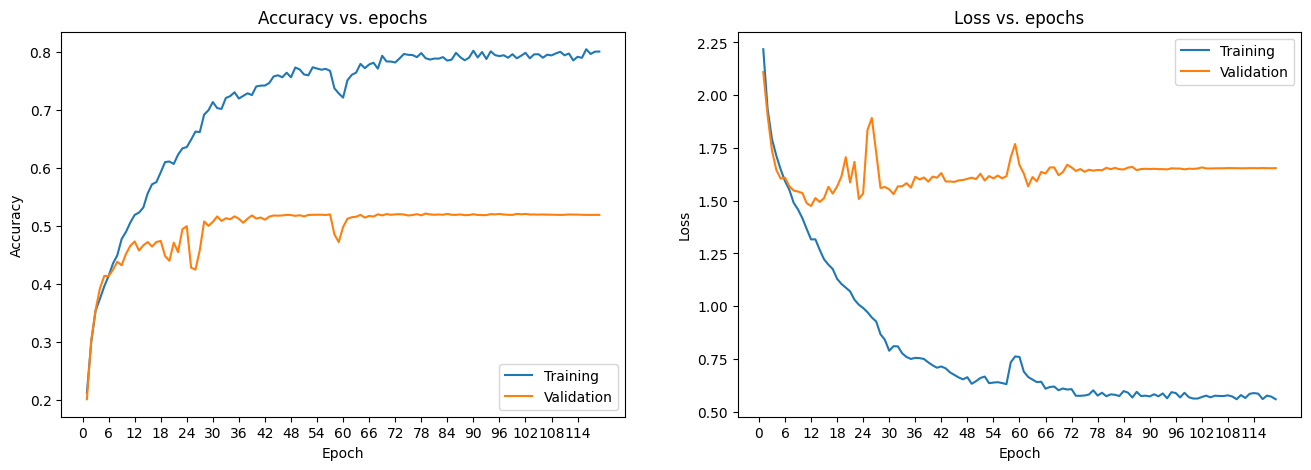

2022-08-09 12:29:07,103: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 2ms/step


2022-08-09 12:29:13,930: INFO: test loss:1.6441
2022-08-09 12:29:13,931: INFO: test accuracy:0.5212
2022-08-09 12:29:13,933: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/results.json
2022-08-09 12:29:13,935: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/results.json
2022-08-09 12:29:13,935: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/default.generator
2022-08-09 12:29:13,936: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/default.generator
2022-08-09 12:29:13,937: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/ml

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-09 12:29:14,251: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/default.generator


313/313 [==============================] - 1s 2ms/step


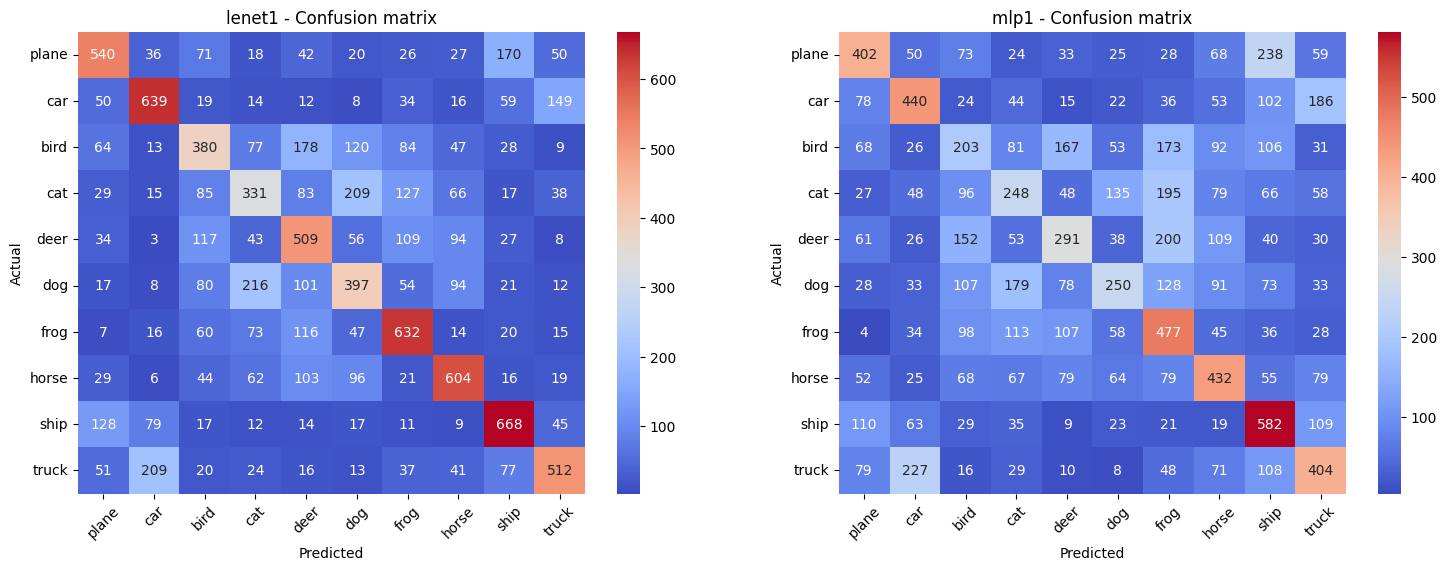

2022-08-09 12:29:18,970: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1


----------------------------------------sample analysis----------------------------------------


2022-08-09 12:29:19,282: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/default.generator
2022-08-09 12:29:19,284: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20
2022-08-09 12:29:24,431: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/default.generator
2022-08-09 12:29:24,433: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1
2022-08-09 12:29:25,429: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/default.generator
2022-08-09 12:29:25,431: INFO: loading model from /tf/eipi10/xuxiangwen.g

1/1 [==============================] - 0s 118ms/step


2022-08-09 12:29:29,821: WARNING: 5 out of the last 631 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f944819bf70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 12ms/step


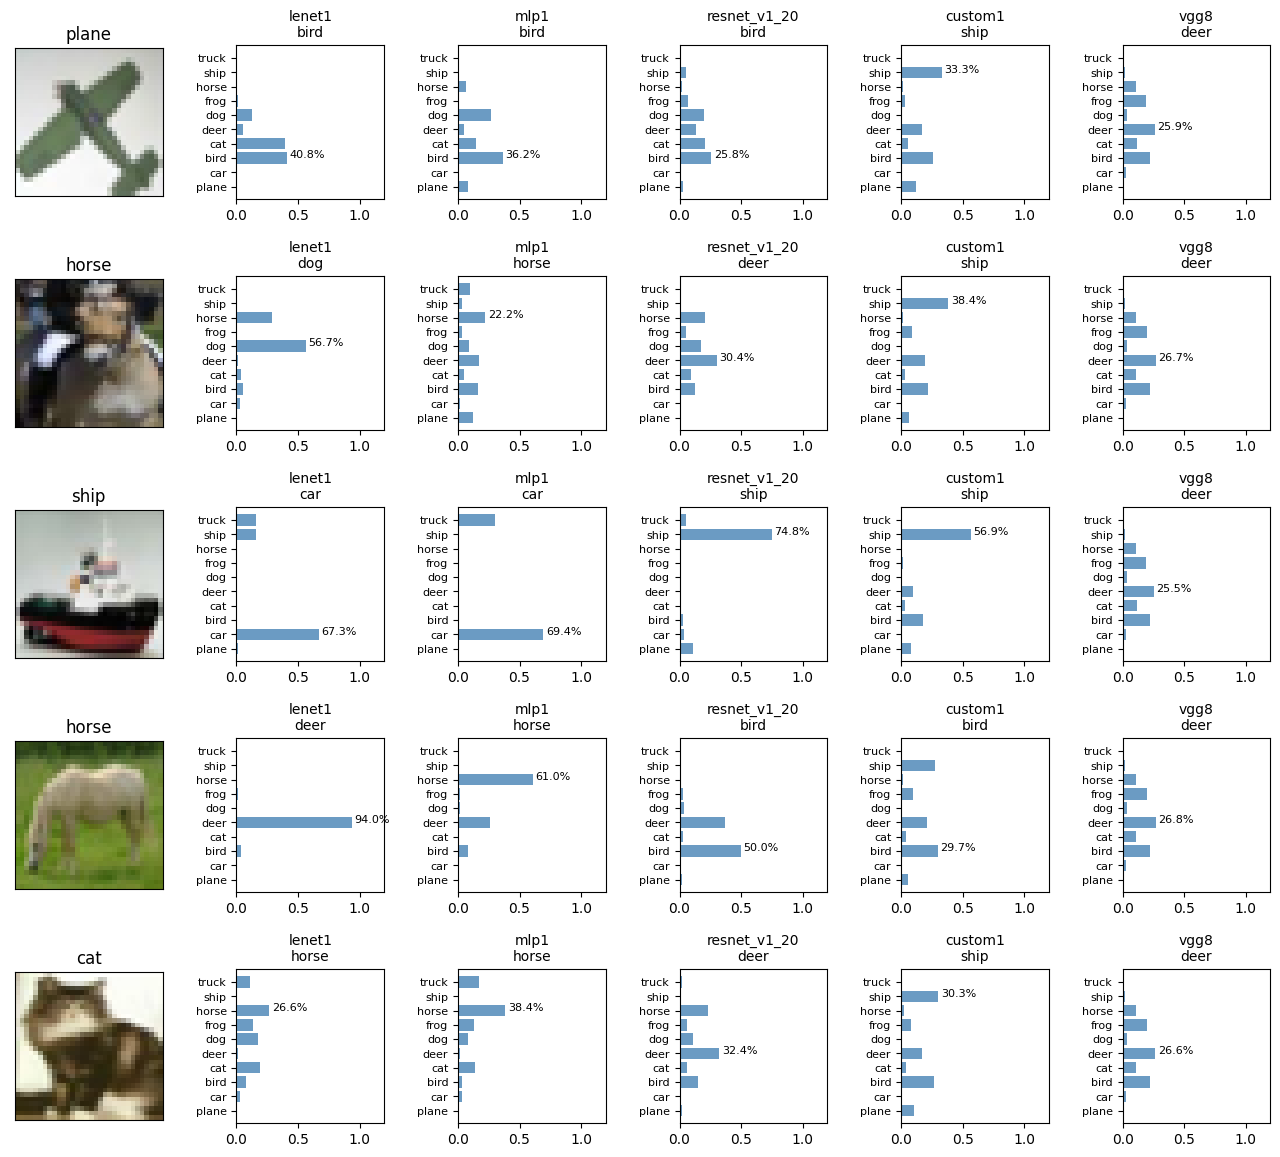

----------------------------------------models----------------------------------------


model_name                  program_name  weight_number  train_time  \
1        lenet1  cifar10_0808_count_500.ipynb          83170       265.6   
2          mlp1  cifar10_0808_count_500.ipynb         394634       128.5   
3  resnet_v1_20  cifar10_0808_count_500.ipynb         273066        18.6   
4       custom1  cifar10_0808_count_500.ipynb          73738         5.0   
5          vgg8  cifar10_0808_count_500.ipynb        1672906         8.9   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-09 12:29      0.2351     1.6441          0.9430         0.5212   
2  2022-08-09 12:24      1.3852     1.8163          0.5162         0.3729   
3  2022-08-09 12:18      2.3461     2.3815          0.2062         0.1980   
4  2022-08-09 12:16      3.2211     3.2277          0.1230         0.1216   
5  2022-08-09 12:17      2.9014     2.9135          0.0972         0.1000   

   train_auc  test_auc  
1     0.9979    0.8911  
2     0.8894    0.8013  
3     0.7818    0.7750  
4     0.7088    0.7067  
5     0.6073    0.6134

In [21]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.lenet1(helper, name='lenet1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

从上面的图中，可以看到，Lenet的参数只有mlp的60%，但其的准确率比mlp提升了差不多1%。上面最后一张图中，有三列，第一列是数字图片，它们是mlp中分错的数字，第二列是mlp中的分类，第三列是lenet中的分类，可以看到lenet的确学到了一些mlp中没有的模式。下面再来看看哪些数字在lenet也分错了。

### Custom 1

下面自己定义一个模型，这个模型和lenet的主要区别是，增加了卷积的深度

2022-08-09 12:29:34,529: INFO: model_params.custom1.dropout=0.2
2022-08-09 12:29:34,640: INFO: learning_rate=0.001
2022-08-09 12:29:34,641: INFO: model_params.custom1.clip_value=None
2022-08-09 12:29:34,648: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1


TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)
Model: "custom1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_2 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 16, 16, 32)        0         
                                                              

2022-08-09 12:29:34,682: INFO: model_params.custom1.epochs=120
2022-08-09 12:29:34,682: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1, monitor=val_accuracy)
2022-08-09 12:29:34,683: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-09 12:29:34,684: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-09 12:29:34,684: INFO: use LearningRateScheduler()
2022-08-09 12:29:34,685: INFO: steps_per_epoch=156
2022-08-09 12:29:34,686: INFO: start training
2022-08-09 12:29:34,686: INFO: use_class_weight=False


Epoch 1/120
155/156 [============================>.] - ETA: 0s - loss: 2.1915 - accuracy: 0.2385

2022-08-09 12:29:39,755: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


2022-08-09 12:29:40,441: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


156/156 [==============================] - 6s 31ms/step - loss: 2.1911 - accuracy: 0.2380 - val_loss: 3.2720 - val_accuracy: 0.1010 - lr: 0.0010
Epoch 2/120
156/156 [==============================] - ETA: 0s - loss: 1.7937 - accuracy: 0.3456

2022-08-09 12:29:44,076: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


2022-08-09 12:29:44,770: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


156/156 [==============================] - 4s 28ms/step - loss: 1.7937 - accuracy: 0.3456 - val_loss: 2.5070 - val_accuracy: 0.1997 - lr: 0.0010
Epoch 3/120
155/156 [============================>.] - ETA: 0s - loss: 1.6617 - accuracy: 0.3913

2022-08-09 12:29:48,938: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


2022-08-09 12:29:49,642: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


156/156 [==============================] - 5s 31ms/step - loss: 1.6633 - accuracy: 0.3918 - val_loss: 2.0845 - val_accuracy: 0.2863 - lr: 0.0010
Epoch 4/120
149/156 [===========================>..] - ETA: 0s - loss: 1.5581 - accuracy: 0.4375

2022-08-09 12:29:53,523: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


2022-08-09 12:29:54,257: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


156/156 [==============================] - 5s 30ms/step - loss: 1.5559 - accuracy: 0.4373 - val_loss: 1.9322 - val_accuracy: 0.3548 - lr: 0.0010
Epoch 5/120
149/156 [===========================>..] - ETA: 0s - loss: 1.4761 - accuracy: 0.4662

2022-08-09 12:29:57,332: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


2022-08-09 12:29:58,018: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


156/156 [==============================] - 4s 24ms/step - loss: 1.4768 - accuracy: 0.4659 - val_loss: 1.6594 - val_accuracy: 0.4108 - lr: 0.0010
Epoch 6/120
156/156 [==============================] - ETA: 0s - loss: 1.4093 - accuracy: 0.4820

2022-08-09 12:30:01,355: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


2022-08-09 12:30:02,019: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


156/156 [==============================] - 4s 26ms/step - loss: 1.4093 - accuracy: 0.4820 - val_loss: 1.4307 - val_accuracy: 0.4757 - lr: 0.0010
Epoch 7/120
156/156 [==============================] - ETA: 0s - loss: 1.3573 - accuracy: 0.5104

2022-08-09 12:30:06,066: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


2022-08-09 12:30:06,724: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


156/156 [==============================] - 5s 30ms/step - loss: 1.3573 - accuracy: 0.5104 - val_loss: 1.4237 - val_accuracy: 0.4861 - lr: 0.0010
Epoch 8/120
156/156 [==============================] - 2s 10ms/step - loss: 1.3062 - accuracy: 0.5337 - val_loss: 1.4663 - val_accuracy: 0.4678 - lr: 0.0010
Epoch 9/120
152/156 [============================>.] - ETA: 0s - loss: 1.2484 - accuracy: 0.5510

2022-08-09 12:30:11,282: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


2022-08-09 12:30:11,982: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


156/156 [==============================] - 4s 24ms/step - loss: 1.2505 - accuracy: 0.5505 - val_loss: 1.4162 - val_accuracy: 0.4940 - lr: 0.0010
Epoch 10/120
156/156 [==============================] - 2s 10ms/step - loss: 1.2064 - accuracy: 0.5629 - val_loss: 1.4893 - val_accuracy: 0.4572 - lr: 0.0010
Epoch 11/120
147/156 [===========================>..] - ETA: 0s - loss: 1.1548 - accuracy: 0.5767

2022-08-09 12:30:16,747: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


2022-08-09 12:30:17,442: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


156/156 [==============================] - 4s 25ms/step - loss: 1.1564 - accuracy: 0.5765 - val_loss: 1.3069 - val_accuracy: 0.5371 - lr: 0.0010
Epoch 12/120
156/156 [==============================] - 2s 10ms/step - loss: 1.1143 - accuracy: 0.6040 - val_loss: 1.8502 - val_accuracy: 0.4083 - lr: 0.0010
Epoch 13/120
156/156 [==============================] - 2s 10ms/step - loss: 1.0855 - accuracy: 0.6062 - val_loss: 1.8587 - val_accuracy: 0.4280 - lr: 0.0010
Epoch 14/120
156/156 [==============================] - 2s 11ms/step - loss: 1.0514 - accuracy: 0.6186 - val_loss: 1.3762 - val_accuracy: 0.5230 - lr: 0.0010
Epoch 15/120
156/156 [==============================] - 2s 10ms/step - loss: 1.0057 - accuracy: 0.6412 - val_loss: 1.4478 - val_accuracy: 0.4910 - lr: 0.0010
Epoch 16/120
156/156 [==============================] - 2s 10ms/step - loss: 0.9823 - accuracy: 0.6458 - val_loss: 1.7123 - val_accuracy: 0.4621 - lr: 0.0010
Epoch 17/120
156/156 [==============================] - 2s 10ms/s

2022-08-09 12:30:43,740: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


2022-08-09 12:30:44,427: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets



Epoch 26: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
156/156 [==============================] - 4s 26ms/step - loss: 0.7396 - accuracy: 0.7344 - val_loss: 1.4901 - val_accuracy: 0.5409 - lr: 3.1623e-04
Epoch 00027: Still keep learning rate 0.0003162 instead of 0.001
Epoch 27/120
155/156 [============================>.] - ETA: 0s - loss: 0.6620 - accuracy: 0.7573

2022-08-09 12:30:48,178: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


2022-08-09 12:30:48,888: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


156/156 [==============================] - 4s 29ms/step - loss: 0.6625 - accuracy: 0.7574 - val_loss: 1.3697 - val_accuracy: 0.5784 - lr: 3.1623e-04
Epoch 00028: Still keep learning rate 0.0003162 instead of 0.001
Epoch 28/120
146/156 [===========================>..] - ETA: 0s - loss: 0.6492 - accuracy: 0.7658

2022-08-09 12:30:52,025: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


2022-08-09 12:30:52,724: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


156/156 [==============================] - 4s 25ms/step - loss: 0.6490 - accuracy: 0.7664 - val_loss: 1.3455 - val_accuracy: 0.5838 - lr: 3.1623e-04
Epoch 00029: Still keep learning rate 0.0003162 instead of 0.001
Epoch 29/120
156/156 [==============================] - 2s 10ms/step - loss: 0.6160 - accuracy: 0.7756 - val_loss: 1.4373 - val_accuracy: 0.5718 - lr: 3.1623e-04
Epoch 00030: Still keep learning rate 0.0003162 instead of 0.001
Epoch 30/120
156/156 [==============================] - 2s 10ms/step - loss: 0.6129 - accuracy: 0.7752 - val_loss: 1.4464 - val_accuracy: 0.5621 - lr: 3.1623e-04
Epoch 00031: Still keep learning rate 0.0003162 instead of 0.001
Epoch 31/120
156/156 [==============================] - 2s 11ms/step - loss: 0.5890 - accuracy: 0.7839 - val_loss: 1.4260 - val_accuracy: 0.5749 - lr: 3.1623e-04
Epoch 00032: Still keep learning rate 0.0003162 instead of 0.001
Epoch 32/120
156/156 [==============================] - 2s 12ms/step - loss: 0.5721 - accuracy: 0.7927 - 

2022-08-09 12:31:05,037: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


2022-08-09 12:31:05,728: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


156/156 [==============================] - 4s 27ms/step - loss: 0.5594 - accuracy: 0.7973 - val_loss: 1.3778 - val_accuracy: 0.5886 - lr: 3.1623e-04
Epoch 00035: Still keep learning rate 0.0003162 instead of 0.001
Epoch 35/120
156/156 [==============================] - 2s 12ms/step - loss: 0.5607 - accuracy: 0.7897 - val_loss: 1.3978 - val_accuracy: 0.5829 - lr: 3.1623e-04
Epoch 00036: Still keep learning rate 0.0003162 instead of 0.001
Epoch 36/120
156/156 [==============================] - 2s 11ms/step - loss: 0.5457 - accuracy: 0.8033 - val_loss: 1.4091 - val_accuracy: 0.5816 - lr: 3.1623e-04
Epoch 00037: Still keep learning rate 0.0003162 instead of 0.001
Epoch 37/120
156/156 [==============================] - 2s 11ms/step - loss: 0.5381 - accuracy: 0.8009 - val_loss: 1.3812 - val_accuracy: 0.5852 - lr: 3.1623e-04
Epoch 00038: Still keep learning rate 0.0003162 instead of 0.001
Epoch 38/120
148/156 [===========================>..] - ETA: 0s - loss: 0.5507 - accuracy: 0.8030

2022-08-09 12:31:14,102: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


2022-08-09 12:31:14,796: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


156/156 [==============================] - 4s 24ms/step - loss: 0.5528 - accuracy: 0.8027 - val_loss: 1.3479 - val_accuracy: 0.5908 - lr: 3.1623e-04
Epoch 00039: Still keep learning rate 0.0003162 instead of 0.001
Epoch 39/120
156/156 [==============================] - 2s 10ms/step - loss: 0.5322 - accuracy: 0.8091 - val_loss: 1.4528 - val_accuracy: 0.5681 - lr: 3.1623e-04
Epoch 00040: Still keep learning rate 0.0003162 instead of 0.001
Epoch 40/120
156/156 [==============================] - 2s 10ms/step - loss: 0.5147 - accuracy: 0.8135 - val_loss: 1.4699 - val_accuracy: 0.5745 - lr: 3.1623e-04
Epoch 00041: Still keep learning rate 0.0003162 instead of 0.001
Epoch 41/120
149/156 [===========================>..] - ETA: 0s - loss: 0.5313 - accuracy: 0.8033

2022-08-09 12:31:21,372: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


2022-08-09 12:31:22,060: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets



Epoch 41: ReduceLROnPlateau reducing learning rate to 0.00010000000639606199.
156/156 [==============================] - 4s 26ms/step - loss: 0.5333 - accuracy: 0.8029 - val_loss: 1.3398 - val_accuracy: 0.5989 - lr: 1.0000e-04
Epoch 00042: Still keep learning rate 0.0001 instead of 0.001
Epoch 42/120
148/156 [===========================>..] - ETA: 0s - loss: 0.4874 - accuracy: 0.8180

2022-08-09 12:31:25,375: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


2022-08-09 12:31:26,031: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


156/156 [==============================] - 4s 25ms/step - loss: 0.4864 - accuracy: 0.8179 - val_loss: 1.2988 - val_accuracy: 0.6087 - lr: 1.0000e-04
Epoch 00043: Still keep learning rate 0.0001 instead of 0.001
Epoch 43/120
155/156 [============================>.] - ETA: 0s - loss: 0.4920 - accuracy: 0.8248

2022-08-09 12:31:29,006: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


2022-08-09 12:31:29,693: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


156/156 [==============================] - 4s 24ms/step - loss: 0.4942 - accuracy: 0.8243 - val_loss: 1.2833 - val_accuracy: 0.6102 - lr: 1.0000e-04
Epoch 00044: Still keep learning rate 0.0001 instead of 0.001
Epoch 44/120
156/156 [==============================] - 2s 11ms/step - loss: 0.4974 - accuracy: 0.8169 - val_loss: 1.3230 - val_accuracy: 0.6003 - lr: 1.0000e-04
Epoch 00045: Still keep learning rate 0.0001 instead of 0.001
Epoch 45/120
156/156 [==============================] - 2s 10ms/step - loss: 0.4647 - accuracy: 0.8309 - val_loss: 1.2948 - val_accuracy: 0.6094 - lr: 1.0000e-04
Epoch 00046: Still keep learning rate 0.0001 instead of 0.001
Epoch 46/120
156/156 [==============================] - 2s 10ms/step - loss: 0.4537 - accuracy: 0.8397 - val_loss: 1.2989 - val_accuracy: 0.6073 - lr: 1.0000e-04
Epoch 00047: Still keep learning rate 0.0001 instead of 0.001
Epoch 47/120
156/156 [==============================] - 3s 17ms/step - loss: 0.4827 - accuracy: 0.8307 - val_loss: 1.

2022-08-09 12:31:54,399: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


2022-08-09 12:31:55,118: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


156/156 [==============================] - 4s 29ms/step - loss: 0.4433 - accuracy: 0.8405 - val_loss: 1.2935 - val_accuracy: 0.6146 - lr: 1.0000e-04
Epoch 00055: Still keep learning rate 0.0001 instead of 0.001
Epoch 55/120
156/156 [==============================] - 2s 14ms/step - loss: 0.4469 - accuracy: 0.8391 - val_loss: 1.3109 - val_accuracy: 0.6115 - lr: 1.0000e-04
Epoch 00056: Still keep learning rate 0.0001 instead of 0.001
Epoch 56/120
156/156 [==============================] - 2s 11ms/step - loss: 0.4356 - accuracy: 0.8484 - val_loss: 1.3217 - val_accuracy: 0.6089 - lr: 1.0000e-04
Epoch 00057: Still keep learning rate 0.0001 instead of 0.001
Epoch 57/120
156/156 [==============================] - 2s 11ms/step - loss: 0.4505 - accuracy: 0.8381 - val_loss: 1.3542 - val_accuracy: 0.6102 - lr: 1.0000e-04
Epoch 00058: Still keep learning rate 0.0001 instead of 0.001
Epoch 58/120
156/156 [==============================] - ETA: 0s - loss: 0.4577 - accuracy: 0.8325
Epoch 58: ReduceLRO

2022-08-09 12:32:27,558: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


2022-08-09 12:32:28,258: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


156/156 [==============================] - 5s 31ms/step - loss: 0.4220 - accuracy: 0.8466 - val_loss: 1.3081 - val_accuracy: 0.6150 - lr: 1.0000e-04
Epoch 71/120
156/156 [==============================] - 2s 12ms/step - loss: 0.4245 - accuracy: 0.8482 - val_loss: 1.3381 - val_accuracy: 0.6116 - lr: 1.0000e-04
Epoch 72/120
150/156 [===========================>..] - ETA: 0s - loss: 0.4261 - accuracy: 0.8481

2022-08-09 12:32:33,173: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


2022-08-09 12:32:33,922: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


156/156 [==============================] - 4s 24ms/step - loss: 0.4269 - accuracy: 0.8476 - val_loss: 1.3389 - val_accuracy: 0.6168 - lr: 1.0000e-04
Epoch 73/120
151/156 [============================>.] - ETA: 0s - loss: 0.4223 - accuracy: 0.8516
Epoch 73: ReduceLROnPlateau reducing learning rate to 3.1622775802825264e-05.
156/156 [==============================] - 3s 17ms/step - loss: 0.4213 - accuracy: 0.8520 - val_loss: 1.3500 - val_accuracy: 0.6146 - lr: 3.1623e-05
Epoch 00074: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 74/120
156/156 [==============================] - 3s 17ms/step - loss: 0.4090 - accuracy: 0.8534 - val_loss: 1.3496 - val_accuracy: 0.6140 - lr: 3.1623e-05
Epoch 00075: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 75/120
156/156 [==============================] - 2s 11ms/step - loss: 0.4142 - accuracy: 0.8510 - val_loss: 1.3394 - val_accuracy: 0.6149 - lr: 3.1623e-05
Epoch 00076: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 7

2022-08-09 12:32:44,240: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


2022-08-09 12:32:44,945: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


156/156 [==============================] - 4s 25ms/step - loss: 0.4104 - accuracy: 0.8478 - val_loss: 1.3360 - val_accuracy: 0.6177 - lr: 3.1623e-05
Epoch 00077: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 77/120
156/156 [==============================] - 2s 14ms/step - loss: 0.4074 - accuracy: 0.8490 - val_loss: 1.3621 - val_accuracy: 0.6133 - lr: 3.1623e-05
Epoch 00078: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 78/120
156/156 [==============================] - 2s 14ms/step - loss: 0.4170 - accuracy: 0.8480 - val_loss: 1.3458 - val_accuracy: 0.6174 - lr: 3.1623e-05
Epoch 00079: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 79/120
156/156 [==============================] - 2s 13ms/step - loss: 0.3903 - accuracy: 0.8590 - val_loss: 1.3411 - val_accuracy: 0.6156 - lr: 3.1623e-05
Epoch 00080: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 80/120
156/156 [==============================] - 2s 10ms/step - loss: 0.4017 - accuracy: 0.8504 - 

2022-08-09 12:33:05,478: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


2022-08-09 12:33:06,153: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1/assets


156/156 [==============================] - 4s 29ms/step - loss: 0.4087 - accuracy: 0.8564 - val_loss: 1.3468 - val_accuracy: 0.6203 - lr: 3.1623e-05
Epoch 00086: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 86/120
156/156 [==============================] - 2s 14ms/step - loss: 0.3949 - accuracy: 0.8566 - val_loss: 1.3674 - val_accuracy: 0.6179 - lr: 3.1623e-05
Epoch 00087: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 87/120
156/156 [==============================] - 2s 11ms/step - loss: 0.3905 - accuracy: 0.8536 - val_loss: 1.3388 - val_accuracy: 0.6195 - lr: 3.1623e-05
Epoch 00088: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 88/120
149/156 [===========================>..] - ETA: 0s - loss: 0.3996 - accuracy: 0.8509
Epoch 88: ReduceLROnPlateau reducing learning rate to 9.999999259090306e-06.
156/156 [==============================] - 2s 11ms/step - loss: 0.3949 - accuracy: 0.8536 - val_loss: 1.3645 - val_accuracy: 0.6169 - lr: 1.0000e-05
Epoch 00

2022-08-09 12:34:20,845: INFO: finish training [elapsed time: 286.16 seconds]


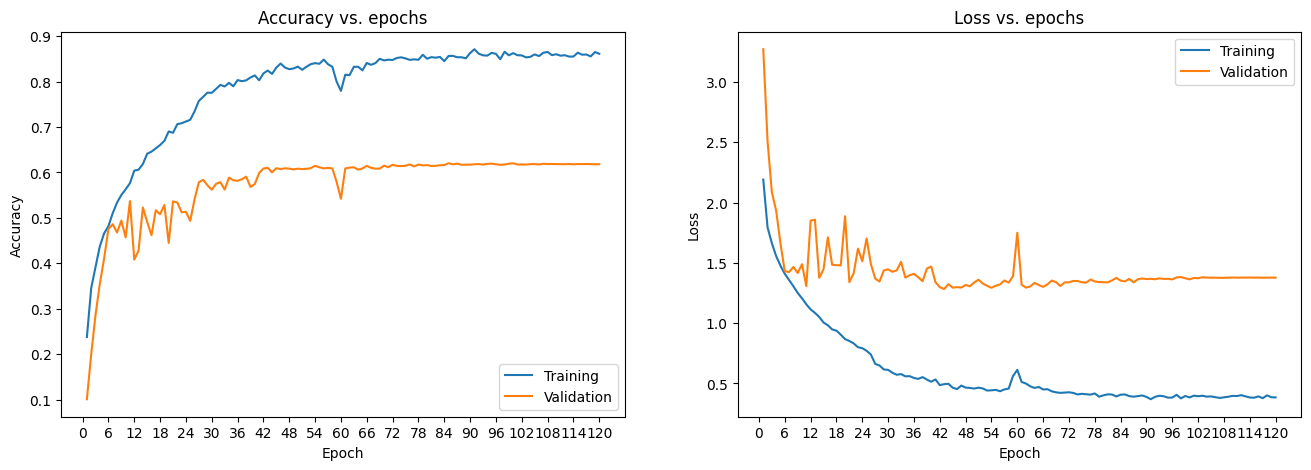

2022-08-09 12:34:21,304: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 3ms/step


2022-08-09 12:34:28,558: INFO: test loss:1.3468
2022-08-09 12:34:28,560: INFO: test accuracy:0.6203
2022-08-09 12:34:28,562: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/results.json
2022-08-09 12:34:28,563: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/results.json
2022-08-09 12:34:28,564: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/default.generator
2022-08-09 12:34:28,565: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/default.generator
2022-08-09 12:34:28,566: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/le

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-09 12:34:29,468: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/default.generator


313/313 [==============================] - 1s 2ms/step


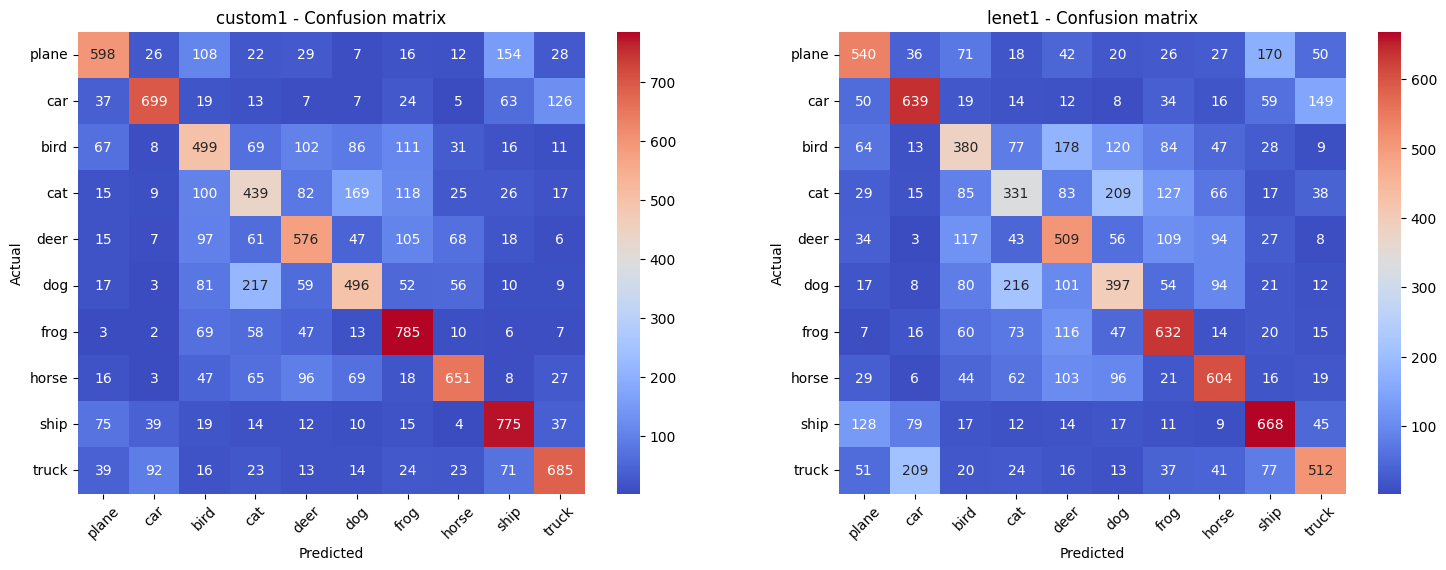

2022-08-09 12:34:34,302: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1


----------------------------------------sample analysis----------------------------------------


2022-08-09 12:34:35,189: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/default.generator
2022-08-09 12:34:35,192: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1
2022-08-09 12:34:35,503: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/default.generator
2022-08-09 12:34:35,505: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20
2022-08-09 12:34:40,570: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/default.generator
2022-08-09 12:34:40,576: INFO: loading model from /tf/eipi10/xuxiangwen.gith

1/1 [==============================] - 0s 12ms/step


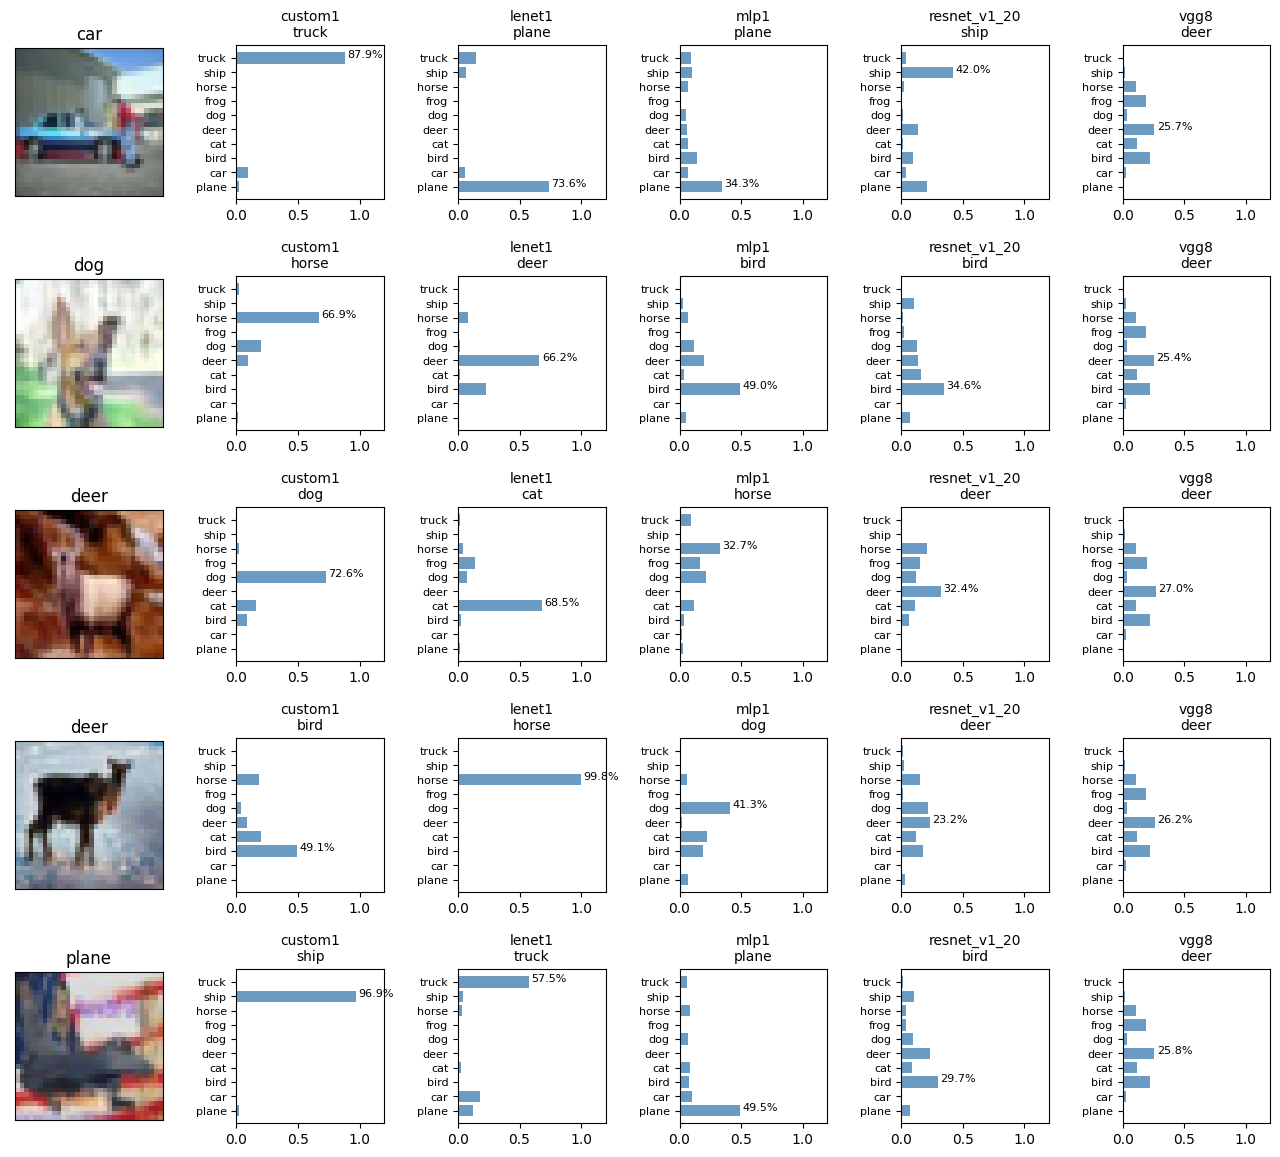

----------------------------------------models----------------------------------------


model_name                  program_name  weight_number  train_time  \
1       custom1  cifar10_0808_count_500.ipynb          73738       286.2   
2        lenet1  cifar10_0808_count_500.ipynb          83170       265.6   
3          mlp1  cifar10_0808_count_500.ipynb         394634       128.5   
4  resnet_v1_20  cifar10_0808_count_500.ipynb         273066        18.6   
5          vgg8  cifar10_0808_count_500.ipynb        1672906         8.9   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-09 12:34      0.1174     1.3468          0.9792         0.6203   
2  2022-08-09 12:29      0.2351     1.6441          0.9430         0.5212   
3  2022-08-09 12:24      1.3852     1.8163          0.5162         0.3729   
4  2022-08-09 12:18      2.3461     2.3815          0.2062         0.1980   
5  2022-08-09 12:17      2.9014     2.9135          0.0972         0.1000   

   train_auc  test_auc  
1     0.9997    0.9283  
2     0.9979    0.8911  
3     0.8894    0.8013  
4     0.7818    0.7750  
5     0.6073    0.6134

In [22]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.custom1(helper, name='custom1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### VGG

2022-08-09 12:34:49,877: INFO: model_params.vgg8.dropout=0.4


TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)


2022-08-09 12:34:50,051: INFO: learning_rate=0.001
2022-08-09 12:34:50,052: INFO: model_params.vgg8.clip_value=None
2022-08-09 12:34:50,058: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8


Model: "vgg8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_con1 (Conv2D)        (None, 32, 32, 64)        1792      
                                                                 
 block1_bn1 (BatchNormalizat  (None, 32, 32, 64)       256       
 ion)                                                            
                                                                 
 block1_relu1 (ReLU)         (None, 32, 32, 64)        0         
                                                                 
 block1_con2 (Conv2D)        (None, 32, 32, 64)        36928     
                                                                 
 block1_bn2 (BatchNormalizat  (None, 32, 32, 64)       256       
 ion)                                                         

2022-08-09 12:34:50,107: INFO: model_params.vgg8.epochs=120
2022-08-09 12:34:50,108: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8, monitor=val_accuracy)
2022-08-09 12:34:50,109: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-09 12:34:50,110: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-09 12:34:50,110: INFO: use LearningRateScheduler()
2022-08-09 12:34:50,111: INFO: steps_per_epoch=156
2022-08-09 12:34:50,112: INFO: start training
2022-08-09 12:34:50,112: INFO: use_class_weight=False


Epoch 1/120
154/156 [============================>.] - ETA: 0s - loss: 2.3971 - accuracy: 0.1305

2022-08-09 12:34:59,620: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:35:00,748: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 11s 59ms/step - loss: 2.3959 - accuracy: 0.1310 - val_loss: 2.4391 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 2/120
154/156 [============================>.] - ETA: 0s - loss: 2.1974 - accuracy: 0.1583

2022-08-09 12:35:08,675: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:35:09,814: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 9s 58ms/step - loss: 2.1969 - accuracy: 0.1589 - val_loss: 2.6541 - val_accuracy: 0.1001 - lr: 0.0010
Epoch 3/120
154/156 [============================>.] - ETA: 0s - loss: 2.1049 - accuracy: 0.1883

2022-08-09 12:35:16,119: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:35:17,250: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 7s 48ms/step - loss: 2.1053 - accuracy: 0.1891 - val_loss: 2.2664 - val_accuracy: 0.1483 - lr: 0.0010
Epoch 4/120
154/156 [============================>.] - ETA: 0s - loss: 2.0410 - accuracy: 0.1798

2022-08-09 12:35:23,926: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:35:25,092: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 8s 50ms/step - loss: 2.0413 - accuracy: 0.1793 - val_loss: 1.9320 - val_accuracy: 0.1973 - lr: 0.0010
Epoch 5/120
156/156 [==============================] - 5s 33ms/step - loss: 2.0119 - accuracy: 0.1813 - val_loss: 2.0466 - val_accuracy: 0.1741 - lr: 0.0010
Epoch 6/120
154/156 [============================>.] - ETA: 0s - loss: 1.9942 - accuracy: 0.1916

2022-08-09 12:35:37,914: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:35:39,075: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 9s 57ms/step - loss: 1.9948 - accuracy: 0.1911 - val_loss: 2.0472 - val_accuracy: 0.1997 - lr: 0.0010
Epoch 7/120
154/156 [============================>.] - ETA: 0s - loss: 1.9825 - accuracy: 0.1912

2022-08-09 12:35:46,638: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:35:47,769: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 9s 56ms/step - loss: 1.9829 - accuracy: 0.1921 - val_loss: 1.8458 - val_accuracy: 0.2611 - lr: 0.0010
Epoch 8/120
156/156 [==============================] - 4s 26ms/step - loss: 1.9590 - accuracy: 0.1923 - val_loss: 2.4290 - val_accuracy: 0.1308 - lr: 0.0010
Epoch 9/120
156/156 [==============================] - 4s 28ms/step - loss: 1.9570 - accuracy: 0.1977 - val_loss: 2.1218 - val_accuracy: 0.1799 - lr: 0.0010
Epoch 10/120
156/156 [==============================] - 3s 22ms/step - loss: 1.9325 - accuracy: 0.2021 - val_loss: 1.8225 - val_accuracy: 0.2296 - lr: 0.0010
Epoch 11/120
156/156 [==============================] - ETA: 0s - loss: 1.9254 - accuracy: 0.2049

2022-08-09 12:36:07,462: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:36:08,605: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 9s 59ms/step - loss: 1.9254 - accuracy: 0.2049 - val_loss: 1.7839 - val_accuracy: 0.2637 - lr: 0.0010
Epoch 12/120
156/156 [==============================] - 3s 22ms/step - loss: 1.9212 - accuracy: 0.2091 - val_loss: 1.8218 - val_accuracy: 0.2512 - lr: 0.0010
Epoch 13/120
156/156 [==============================] - 5s 33ms/step - loss: 1.9131 - accuracy: 0.2139 - val_loss: 1.8217 - val_accuracy: 0.2521 - lr: 0.0010
Epoch 14/120
156/156 [==============================] - 5s 33ms/step - loss: 1.9154 - accuracy: 0.2063 - val_loss: 1.8538 - val_accuracy: 0.2508 - lr: 0.0010
Epoch 15/120
155/156 [============================>.] - ETA: 0s - loss: 1.9098 - accuracy: 0.2210

2022-08-09 12:36:29,342: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:36:30,538: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 8s 53ms/step - loss: 1.9107 - accuracy: 0.2210 - val_loss: 1.8232 - val_accuracy: 0.2687 - lr: 0.0010
Epoch 16/120
156/156 [==============================] - 5s 32ms/step - loss: 1.8987 - accuracy: 0.2151 - val_loss: 1.8653 - val_accuracy: 0.2478 - lr: 0.0010
Epoch 17/120
156/156 [==============================] - 5s 30ms/step - loss: 1.8823 - accuracy: 0.2240 - val_loss: 1.8743 - val_accuracy: 0.2420 - lr: 0.0010
Epoch 18/120
153/156 [============================>.] - ETA: 0s - loss: 1.8986 - accuracy: 0.2216

2022-08-09 12:36:47,815: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:36:48,964: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 9s 56ms/step - loss: 1.8992 - accuracy: 0.2224 - val_loss: 1.8213 - val_accuracy: 0.2744 - lr: 0.0010
Epoch 19/120
154/156 [============================>.] - ETA: 0s - loss: 1.8798 - accuracy: 0.2271

2022-08-09 12:36:56,141: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:36:57,272: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 8s 53ms/step - loss: 1.8804 - accuracy: 0.2268 - val_loss: 1.9006 - val_accuracy: 0.2753 - lr: 0.0010
Epoch 20/120
152/156 [============================>.] - ETA: 0s - loss: 1.8778 - accuracy: 0.2301

2022-08-09 12:37:02,945: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:37:04,122: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 7s 44ms/step - loss: 1.8793 - accuracy: 0.2304 - val_loss: 1.8578 - val_accuracy: 0.2970 - lr: 0.0010
Epoch 21/120
156/156 [==============================] - 3s 22ms/step - loss: 1.8720 - accuracy: 0.2296 - val_loss: 1.8156 - val_accuracy: 0.2944 - lr: 0.0010
Epoch 22/120
156/156 [==============================] - 3s 19ms/step - loss: 1.8251 - accuracy: 0.2514 - val_loss: 1.9019 - val_accuracy: 0.2681 - lr: 0.0010
Epoch 23/120
156/156 [==============================] - 3s 18ms/step - loss: 1.8161 - accuracy: 0.2568 - val_loss: 1.8435 - val_accuracy: 0.2589 - lr: 0.0010
Epoch 24/120
156/156 [==============================] - 3s 22ms/step - loss: 1.7950 - accuracy: 0.2522 - val_loss: 1.8265 - val_accuracy: 0.2872 - lr: 0.0010
Epoch 25/120
153/156 [============================>.] - ETA: 0s - loss: 1.7792 - accuracy: 0.2731

2022-08-09 12:37:22,259: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:37:23,352: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 7s 43ms/step - loss: 1.7806 - accuracy: 0.2728 - val_loss: 1.6732 - val_accuracy: 0.3098 - lr: 0.0010
Epoch 26/120
156/156 [==============================] - 4s 23ms/step - loss: 1.7653 - accuracy: 0.2810 - val_loss: 1.8383 - val_accuracy: 0.2589 - lr: 0.0010
Epoch 27/120
155/156 [============================>.] - ETA: 0s - loss: 1.7624 - accuracy: 0.2692

2022-08-09 12:37:33,143: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:37:34,192: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 7s 46ms/step - loss: 1.7621 - accuracy: 0.2694 - val_loss: 1.6916 - val_accuracy: 0.3351 - lr: 0.0010
Epoch 28/120
155/156 [============================>.] - ETA: 0s - loss: 1.7422 - accuracy: 0.2879

2022-08-09 12:37:39,761: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:37:40,836: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 7s 43ms/step - loss: 1.7425 - accuracy: 0.2879 - val_loss: 1.6944 - val_accuracy: 0.3384 - lr: 0.0010
Epoch 29/120
156/156 [==============================] - 3s 18ms/step - loss: 1.7174 - accuracy: 0.2919 - val_loss: 1.8334 - val_accuracy: 0.3087 - lr: 0.0010
Epoch 30/120
156/156 [==============================] - 3s 18ms/step - loss: 1.7241 - accuracy: 0.2939 - val_loss: 1.7533 - val_accuracy: 0.2862 - lr: 0.0010
Epoch 31/120
151/156 [============================>.] - ETA: 0s - loss: 1.7385 - accuracy: 0.2887

2022-08-09 12:37:51,497: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:37:52,603: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 6s 40ms/step - loss: 1.7427 - accuracy: 0.2899 - val_loss: 1.6420 - val_accuracy: 0.3434 - lr: 0.0010
Epoch 32/120
156/156 [==============================] - 3s 22ms/step - loss: 1.7097 - accuracy: 0.3007 - val_loss: 1.7942 - val_accuracy: 0.3409 - lr: 0.0010
Epoch 33/120
153/156 [============================>.] - ETA: 0s - loss: 1.7010 - accuracy: 0.3056

2022-08-09 12:38:02,217: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:38:03,287: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 7s 47ms/step - loss: 1.7001 - accuracy: 0.3069 - val_loss: 1.6788 - val_accuracy: 0.3473 - lr: 0.0010
Epoch 34/120
154/156 [============================>.] - ETA: 0s - loss: 1.6916 - accuracy: 0.3137

2022-08-09 12:38:08,333: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:38:09,378: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 6s 39ms/step - loss: 1.6927 - accuracy: 0.3133 - val_loss: 1.5838 - val_accuracy: 0.4011 - lr: 0.0010
Epoch 35/120
156/156 [==============================] - 3s 18ms/step - loss: 1.6938 - accuracy: 0.3185 - val_loss: 1.5627 - val_accuracy: 0.3927 - lr: 0.0010
Epoch 36/120
156/156 [==============================] - 3s 22ms/step - loss: 1.6786 - accuracy: 0.3291 - val_loss: 1.5923 - val_accuracy: 0.3881 - lr: 0.0010
Epoch 37/120
156/156 [==============================] - 3s 22ms/step - loss: 1.6626 - accuracy: 0.3337 - val_loss: 1.8659 - val_accuracy: 0.3175 - lr: 0.0010
Epoch 38/120
153/156 [============================>.] - ETA: 0s - loss: 1.6513 - accuracy: 0.3325

2022-08-09 12:38:25,070: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:38:26,164: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 7s 46ms/step - loss: 1.6513 - accuracy: 0.3345 - val_loss: 1.5458 - val_accuracy: 0.4079 - lr: 0.0010
Epoch 39/120
156/156 [==============================] - 3s 18ms/step - loss: 1.6084 - accuracy: 0.3626 - val_loss: 1.6865 - val_accuracy: 0.3698 - lr: 0.0010
Epoch 40/120
156/156 [==============================] - ETA: 0s - loss: 1.5685 - accuracy: 0.3794

2022-08-09 12:38:34,219: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:38:35,335: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 6s 41ms/step - loss: 1.5685 - accuracy: 0.3794 - val_loss: 1.5375 - val_accuracy: 0.4101 - lr: 0.0010
Epoch 41/120
156/156 [==============================] - 3s 22ms/step - loss: 1.5794 - accuracy: 0.3720 - val_loss: 1.8509 - val_accuracy: 0.3577 - lr: 0.0010
Epoch 42/120
155/156 [============================>.] - ETA: 0s - loss: 1.5542 - accuracy: 0.3913

2022-08-09 12:38:44,178: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:38:45,213: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 6s 41ms/step - loss: 1.5549 - accuracy: 0.3914 - val_loss: 1.5059 - val_accuracy: 0.4224 - lr: 0.0010
Epoch 43/120
156/156 [==============================] - 3s 18ms/step - loss: 1.5166 - accuracy: 0.4020 - val_loss: 2.3467 - val_accuracy: 0.3211 - lr: 0.0010
Epoch 44/120
153/156 [============================>.] - ETA: 0s - loss: 1.5232 - accuracy: 0.3999

2022-08-09 12:38:53,526: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:38:54,571: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 7s 42ms/step - loss: 1.5228 - accuracy: 0.4002 - val_loss: 1.5033 - val_accuracy: 0.4366 - lr: 0.0010
Epoch 45/120
156/156 [==============================] - ETA: 0s - loss: 1.4956 - accuracy: 0.4105

2022-08-09 12:38:59,666: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:39:00,768: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 6s 40ms/step - loss: 1.4956 - accuracy: 0.4105 - val_loss: 1.4787 - val_accuracy: 0.4384 - lr: 0.0010
Epoch 46/120
152/156 [============================>.] - ETA: 0s - loss: 1.4938 - accuracy: 0.4089

2022-08-09 12:39:06,432: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:39:07,556: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 7s 44ms/step - loss: 1.4966 - accuracy: 0.4077 - val_loss: 1.4676 - val_accuracy: 0.4553 - lr: 0.0010
Epoch 47/120
156/156 [==============================] - 3s 18ms/step - loss: 1.4612 - accuracy: 0.4201 - val_loss: 1.5419 - val_accuracy: 0.4182 - lr: 0.0010
Epoch 48/120
156/156 [==============================] - ETA: 0s - loss: 1.4639 - accuracy: 0.4329

2022-08-09 12:39:15,597: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:39:16,719: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 6s 41ms/step - loss: 1.4639 - accuracy: 0.4329 - val_loss: 1.4926 - val_accuracy: 0.4579 - lr: 0.0010
Epoch 49/120
153/156 [============================>.] - ETA: 0s - loss: 1.4345 - accuracy: 0.4310

2022-08-09 12:39:22,836: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:39:23,998: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 7s 47ms/step - loss: 1.4338 - accuracy: 0.4325 - val_loss: 1.5368 - val_accuracy: 0.4745 - lr: 0.0010
Epoch 50/120
156/156 [==============================] - ETA: 0s - loss: 1.4512 - accuracy: 0.4385

2022-08-09 12:39:29,366: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:39:30,511: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 6s 42ms/step - loss: 1.4512 - accuracy: 0.4385 - val_loss: 1.4444 - val_accuracy: 0.4778 - lr: 0.0010
Epoch 51/120
156/156 [==============================] - 3s 21ms/step - loss: 1.4573 - accuracy: 0.4297 - val_loss: 1.4483 - val_accuracy: 0.4612 - lr: 0.0010
Epoch 52/120
156/156 [==============================] - 3s 20ms/step - loss: 1.4341 - accuracy: 0.4377 - val_loss: 1.4732 - val_accuracy: 0.4715 - lr: 0.0010
Epoch 53/120
156/156 [==============================] - 3s 19ms/step - loss: 1.3950 - accuracy: 0.4517 - val_loss: 1.4924 - val_accuracy: 0.4510 - lr: 0.0010
Epoch 54/120
153/156 [============================>.] - ETA: 0s - loss: 1.3873 - accuracy: 0.4575

2022-08-09 12:39:45,159: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:39:46,252: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 6s 41ms/step - loss: 1.3886 - accuracy: 0.4579 - val_loss: 1.3884 - val_accuracy: 0.5139 - lr: 0.0010
Epoch 55/120
156/156 [==============================] - 4s 23ms/step - loss: 1.3844 - accuracy: 0.4635 - val_loss: 1.4309 - val_accuracy: 0.4628 - lr: 0.0010
Epoch 56/120
156/156 [==============================] - 3s 19ms/step - loss: 1.3423 - accuracy: 0.4716 - val_loss: 1.4670 - val_accuracy: 0.4855 - lr: 0.0010
Epoch 57/120
156/156 [==============================] - 3s 18ms/step - loss: 1.3564 - accuracy: 0.4702 - val_loss: 1.6785 - val_accuracy: 0.4706 - lr: 0.0010
Epoch 58/120
156/156 [==============================] - ETA: 0s - loss: 1.3031 - accuracy: 0.4952

2022-08-09 12:40:01,501: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:40:02,649: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 7s 46ms/step - loss: 1.3031 - accuracy: 0.4952 - val_loss: 1.4324 - val_accuracy: 0.5145 - lr: 0.0010
Epoch 59/120
156/156 [==============================] - 3s 19ms/step - loss: 1.2568 - accuracy: 0.5076 - val_loss: 1.3765 - val_accuracy: 0.5128 - lr: 0.0010
Epoch 60/120
156/156 [==============================] - ETA: 0s - loss: 1.2104 - accuracy: 0.5214

2022-08-09 12:40:11,143: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:40:12,287: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 7s 42ms/step - loss: 1.2104 - accuracy: 0.5214 - val_loss: 1.3299 - val_accuracy: 0.5444 - lr: 0.0010
Epoch 00061: LearningRateScheduler reducing learning rate to 0.0001 from 0.001.
Epoch 61/120
155/156 [============================>.] - ETA: 0s - loss: 1.1423 - accuracy: 0.5593

2022-08-09 12:40:18,446: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:40:19,745: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 7s 48ms/step - loss: 1.1409 - accuracy: 0.5599 - val_loss: 1.2592 - val_accuracy: 0.5914 - lr: 1.0000e-04
Epoch 62/120
156/156 [==============================] - 3s 19ms/step - loss: 1.1321 - accuracy: 0.5555 - val_loss: 1.2442 - val_accuracy: 0.5848 - lr: 1.0000e-04
Epoch 63/120
156/156 [==============================] - 3s 19ms/step - loss: 1.1231 - accuracy: 0.5645 - val_loss: 1.2444 - val_accuracy: 0.5880 - lr: 1.0000e-04
Epoch 64/120
153/156 [============================>.] - ETA: 0s - loss: 1.0945 - accuracy: 0.5774

2022-08-09 12:40:31,301: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:40:32,534: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 7s 44ms/step - loss: 1.0953 - accuracy: 0.5755 - val_loss: 1.2581 - val_accuracy: 0.5981 - lr: 1.0000e-04
Epoch 65/120
156/156 [==============================] - ETA: 0s - loss: 1.0898 - accuracy: 0.5791

2022-08-09 12:40:38,532: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:40:39,742: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 7s 46ms/step - loss: 1.0898 - accuracy: 0.5791 - val_loss: 1.2501 - val_accuracy: 0.6101 - lr: 1.0000e-04
Epoch 66/120
153/156 [============================>.] - ETA: 0s - loss: 1.0801 - accuracy: 0.5860

2022-08-09 12:40:45,694: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:40:46,849: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 7s 46ms/step - loss: 1.0819 - accuracy: 0.5857 - val_loss: 1.2358 - val_accuracy: 0.6122 - lr: 1.0000e-04
Epoch 67/120
153/156 [============================>.] - ETA: 0s - loss: 1.0702 - accuracy: 0.5915

2022-08-09 12:40:52,869: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:40:53,994: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 7s 46ms/step - loss: 1.0715 - accuracy: 0.5917 - val_loss: 1.2532 - val_accuracy: 0.6123 - lr: 1.0000e-04
Epoch 68/120
153/156 [============================>.] - ETA: 0s - loss: 1.0563 - accuracy: 0.6042

2022-08-09 12:41:00,468: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:41:01,620: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 8s 49ms/step - loss: 1.0557 - accuracy: 0.6042 - val_loss: 1.2545 - val_accuracy: 0.6208 - lr: 1.0000e-04
Epoch 69/120
156/156 [==============================] - 3s 19ms/step - loss: 1.0349 - accuracy: 0.6048 - val_loss: 1.2322 - val_accuracy: 0.6186 - lr: 1.0000e-04
Epoch 70/120
156/156 [==============================] - ETA: 0s - loss: 1.0466 - accuracy: 0.6018

2022-08-09 12:41:10,114: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:41:11,263: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 7s 43ms/step - loss: 1.0466 - accuracy: 0.6018 - val_loss: 1.2453 - val_accuracy: 0.6260 - lr: 1.0000e-04
Epoch 71/120
156/156 [==============================] - 3s 19ms/step - loss: 1.0125 - accuracy: 0.6146 - val_loss: 1.2413 - val_accuracy: 0.6229 - lr: 1.0000e-04
Epoch 72/120
156/156 [==============================] - ETA: 0s - loss: 0.9664 - accuracy: 0.6178

2022-08-09 12:41:20,059: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:41:21,216: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 7s 46ms/step - loss: 0.9664 - accuracy: 0.6178 - val_loss: 1.2639 - val_accuracy: 0.6318 - lr: 1.0000e-04
Epoch 73/120
153/156 [============================>.] - ETA: 0s - loss: 0.9327 - accuracy: 0.6391

2022-08-09 12:41:27,314: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:41:28,447: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 7s 46ms/step - loss: 0.9349 - accuracy: 0.6384 - val_loss: 1.1963 - val_accuracy: 0.6371 - lr: 1.0000e-04
Epoch 74/120
156/156 [==============================] - 3s 21ms/step - loss: 0.9341 - accuracy: 0.6348 - val_loss: 1.2012 - val_accuracy: 0.6357 - lr: 1.0000e-04
Epoch 75/120
156/156 [==============================] - ETA: 0s - loss: 0.9329 - accuracy: 0.6384

2022-08-09 12:41:37,576: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:41:38,752: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 7s 45ms/step - loss: 0.9329 - accuracy: 0.6384 - val_loss: 1.1938 - val_accuracy: 0.6432 - lr: 1.0000e-04
Epoch 76/120
156/156 [==============================] - ETA: 0s - loss: 0.9081 - accuracy: 0.6534

2022-08-09 12:41:44,431: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:41:45,573: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 7s 44ms/step - loss: 0.9081 - accuracy: 0.6534 - val_loss: 1.1997 - val_accuracy: 0.6435 - lr: 1.0000e-04
Epoch 77/120
156/156 [==============================] - 3s 20ms/step - loss: 0.9307 - accuracy: 0.6406 - val_loss: 1.1858 - val_accuracy: 0.6435 - lr: 1.0000e-04
Epoch 78/120
156/156 [==============================] - 3s 19ms/step - loss: 0.8949 - accuracy: 0.6470 - val_loss: 1.2071 - val_accuracy: 0.6430 - lr: 1.0000e-04
Epoch 79/120
156/156 [==============================] - ETA: 0s - loss: 0.8882 - accuracy: 0.6573

2022-08-09 12:41:57,158: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:41:58,337: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 7s 42ms/step - loss: 0.8882 - accuracy: 0.6573 - val_loss: 1.1857 - val_accuracy: 0.6473 - lr: 1.0000e-04
Epoch 80/120
156/156 [==============================] - 3s 22ms/step - loss: 0.8850 - accuracy: 0.6540 - val_loss: 1.1977 - val_accuracy: 0.6468 - lr: 1.0000e-04
Epoch 81/120
156/156 [==============================] - ETA: 0s - loss: 0.8710 - accuracy: 0.6651

2022-08-09 12:42:07,722: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:42:08,887: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 7s 46ms/step - loss: 0.8710 - accuracy: 0.6651 - val_loss: 1.1831 - val_accuracy: 0.6482 - lr: 1.0000e-04
Epoch 82/120
156/156 [==============================] - ETA: 0s - loss: 0.8869 - accuracy: 0.6655

2022-08-09 12:42:14,426: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:42:15,573: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 7s 43ms/step - loss: 0.8869 - accuracy: 0.6655 - val_loss: 1.1831 - val_accuracy: 0.6486 - lr: 1.0000e-04
Epoch 83/120
156/156 [==============================] - ETA: 0s - loss: 0.8493 - accuracy: 0.6719

2022-08-09 12:42:21,431: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:42:22,736: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 7s 46ms/step - loss: 0.8493 - accuracy: 0.6719 - val_loss: 1.1859 - val_accuracy: 0.6546 - lr: 1.0000e-04
Epoch 84/120
156/156 [==============================] - 3s 20ms/step - loss: 0.8353 - accuracy: 0.6747 - val_loss: 1.1973 - val_accuracy: 0.6490 - lr: 1.0000e-04
Epoch 85/120
156/156 [==============================] - 4s 23ms/step - loss: 0.8500 - accuracy: 0.6683 - val_loss: 1.1779 - val_accuracy: 0.6504 - lr: 1.0000e-04
Epoch 86/120
156/156 [==============================] - 3s 19ms/step - loss: 0.8146 - accuracy: 0.6897 - val_loss: 1.1671 - val_accuracy: 0.6534 - lr: 1.0000e-04
Epoch 87/120
156/156 [==============================] - ETA: 0s - loss: 0.8315 - accuracy: 0.6731

2022-08-09 12:42:37,735: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:42:38,851: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 7s 42ms/step - loss: 0.8315 - accuracy: 0.6731 - val_loss: 1.1916 - val_accuracy: 0.6561 - lr: 1.0000e-04
Epoch 88/120
156/156 [==============================] - 3s 22ms/step - loss: 0.8277 - accuracy: 0.6779 - val_loss: 1.1737 - val_accuracy: 0.6549 - lr: 1.0000e-04
Epoch 89/120
156/156 [==============================] - 3s 22ms/step - loss: 0.8123 - accuracy: 0.6875 - val_loss: 1.2016 - val_accuracy: 0.6525 - lr: 1.0000e-04
Epoch 90/120
156/156 [==============================] - 3s 22ms/step - loss: 0.8100 - accuracy: 0.6915 - val_loss: 1.1905 - val_accuracy: 0.6527 - lr: 1.0000e-04
Epoch 00091: LearningRateScheduler reducing learning rate to 1e-05 from 0.0001.
Epoch 91/120
154/156 [============================>.] - ETA: 0s - loss: 0.8014 - accuracy: 0.6938

2022-08-09 12:42:55,567: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:42:56,748: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 8s 48ms/step - loss: 0.8037 - accuracy: 0.6917 - val_loss: 1.1923 - val_accuracy: 0.6580 - lr: 1.0000e-05
Epoch 92/120
156/156 [==============================] - ETA: 0s - loss: 0.7956 - accuracy: 0.6897

2022-08-09 12:43:01,893: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:43:02,985: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 6s 40ms/step - loss: 0.7956 - accuracy: 0.6897 - val_loss: 1.1898 - val_accuracy: 0.6581 - lr: 1.0000e-05
Epoch 93/120
151/156 [============================>.] - ETA: 0s - loss: 0.7886 - accuracy: 0.6950

2022-08-09 12:43:08,262: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:43:09,396: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 6s 42ms/step - loss: 0.7949 - accuracy: 0.6917 - val_loss: 1.1845 - val_accuracy: 0.6589 - lr: 1.0000e-05
Epoch 94/120
156/156 [==============================] - ETA: 0s - loss: 0.7879 - accuracy: 0.6961

2022-08-09 12:43:15,838: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:43:16,988: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 8s 49ms/step - loss: 0.7879 - accuracy: 0.6961 - val_loss: 1.1905 - val_accuracy: 0.6609 - lr: 1.0000e-05
Epoch 95/120
156/156 [==============================] - 4s 23ms/step - loss: 0.8034 - accuracy: 0.6957 - val_loss: 1.1834 - val_accuracy: 0.6603 - lr: 1.0000e-05
Epoch 96/120
156/156 [==============================] - 4s 23ms/step - loss: 0.7901 - accuracy: 0.6905 - val_loss: 1.1843 - val_accuracy: 0.6605 - lr: 1.0000e-05
Epoch 97/120
153/156 [============================>.] - ETA: 0s - loss: 0.7749 - accuracy: 0.7042

2022-08-09 12:43:30,431: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:43:31,549: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 7s 47ms/step - loss: 0.7756 - accuracy: 0.7035 - val_loss: 1.1898 - val_accuracy: 0.6623 - lr: 1.0000e-05
Epoch 98/120
156/156 [==============================] - 4s 24ms/step - loss: 0.7928 - accuracy: 0.6981 - val_loss: 1.1868 - val_accuracy: 0.6621 - lr: 1.0000e-05
Epoch 99/120
156/156 [==============================] - 4s 24ms/step - loss: 0.8034 - accuracy: 0.6903 - val_loss: 1.1814 - val_accuracy: 0.6603 - lr: 1.0000e-05
Epoch 100/120
156/156 [==============================] - 4s 24ms/step - loss: 0.7895 - accuracy: 0.6937 - val_loss: 1.1845 - val_accuracy: 0.6615 - lr: 1.0000e-05
Epoch 101/120
153/156 [============================>.] - ETA: 0s - loss: 0.7849 - accuracy: 0.6936

2022-08-09 12:43:49,165: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:43:50,343: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets



Epoch 101: ReduceLROnPlateau reducing learning rate to 3.1622775802825263e-06.
156/156 [==============================] - 8s 49ms/step - loss: 0.7854 - accuracy: 0.6931 - val_loss: 1.1865 - val_accuracy: 0.6625 - lr: 3.1623e-06
Epoch 00102: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 102/120
156/156 [==============================] - 4s 23ms/step - loss: 0.7932 - accuracy: 0.7017 - val_loss: 1.1869 - val_accuracy: 0.6621 - lr: 3.1623e-06
Epoch 00103: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 103/120
156/156 [==============================] - 4s 23ms/step - loss: 0.7890 - accuracy: 0.6945 - val_loss: 1.1857 - val_accuracy: 0.6622 - lr: 3.1623e-06
Epoch 00104: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 104/120
156/156 [==============================] - 3s 21ms/step - loss: 0.8056 - accuracy: 0.6927 - val_loss: 1.1875 - val_accuracy: 0.6619 - lr: 3.1623e-06
Epoch 00105: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 105/120
156/156 [=======

2022-08-09 12:44:12,183: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:44:13,341: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 7s 44ms/step - loss: 0.8173 - accuracy: 0.6837 - val_loss: 1.1857 - val_accuracy: 0.6626 - lr: 1.0000e-06
Epoch 108/120
156/156 [==============================] - 3s 18ms/step - loss: 0.7954 - accuracy: 0.6915 - val_loss: 1.1872 - val_accuracy: 0.6622 - lr: 1.0000e-06
Epoch 109/120
156/156 [==============================] - 3s 19ms/step - loss: 0.7913 - accuracy: 0.7005 - val_loss: 1.1870 - val_accuracy: 0.6625 - lr: 1.0000e-06
Epoch 110/120
156/156 [==============================] - 3s 19ms/step - loss: 0.8031 - accuracy: 0.6875 - val_loss: 1.1872 - val_accuracy: 0.6626 - lr: 1.0000e-06
Epoch 111/120
154/156 [============================>.] - ETA: 0s - loss: 0.7794 - accuracy: 0.6956

2022-08-09 12:44:28,293: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:44:29,480: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 7s 48ms/step - loss: 0.7805 - accuracy: 0.6951 - val_loss: 1.1867 - val_accuracy: 0.6628 - lr: 1.0000e-06
Epoch 112/120
156/156 [==============================] - ETA: 0s - loss: 0.7906 - accuracy: 0.7029

2022-08-09 12:44:35,088: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


2022-08-09 12:44:36,229: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8/assets


156/156 [==============================] - 7s 43ms/step - loss: 0.7906 - accuracy: 0.7029 - val_loss: 1.1857 - val_accuracy: 0.6629 - lr: 1.0000e-06
Epoch 113/120
156/156 [==============================] - 4s 23ms/step - loss: 0.7951 - accuracy: 0.6957 - val_loss: 1.1859 - val_accuracy: 0.6626 - lr: 1.0000e-06
Epoch 114/120
156/156 [==============================] - 4s 24ms/step - loss: 0.8059 - accuracy: 0.6919 - val_loss: 1.1857 - val_accuracy: 0.6623 - lr: 1.0000e-06
Epoch 115/120
156/156 [==============================] - 4s 24ms/step - loss: 0.7936 - accuracy: 0.6919 - val_loss: 1.1860 - val_accuracy: 0.6626 - lr: 1.0000e-06
Epoch 116/120
155/156 [============================>.] - ETA: 0s - loss: 0.7914 - accuracy: 0.6935
Epoch 116: ReduceLROnPlateau reducing learning rate to 5e-07.
156/156 [==============================] - 4s 23ms/step - loss: 0.7912 - accuracy: 0.6935 - val_loss: 1.1881 - val_accuracy: 0.6626 - lr: 5.0000e-07
Epoch 00117: Still keep learning rate 5e-07 instead 

2022-08-09 12:45:05,677: INFO: finish training [elapsed time: 615.57 seconds]


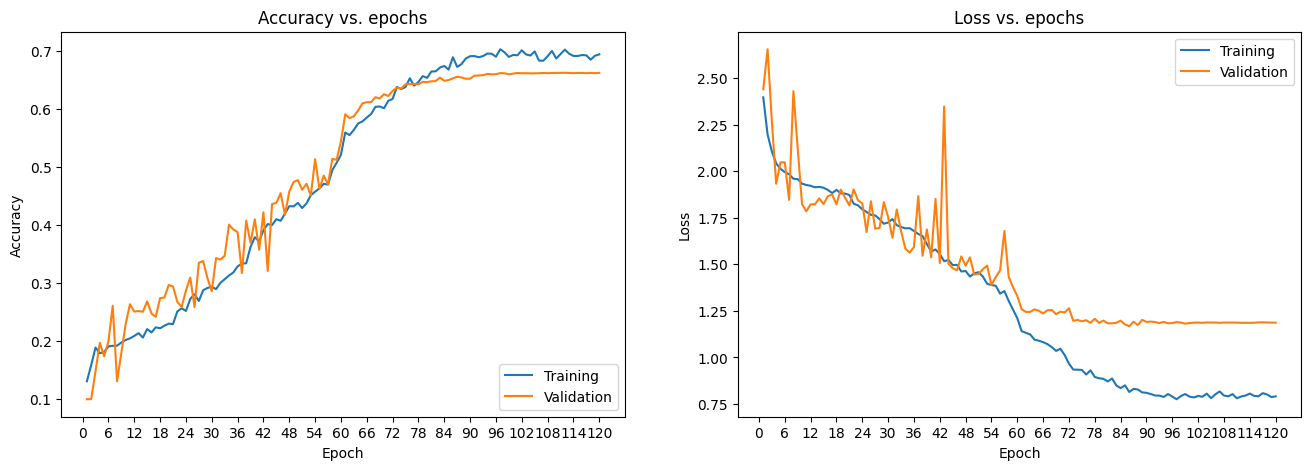

2022-08-09 12:45:06,233: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 4ms/step


2022-08-09 12:45:14,888: INFO: test loss:1.1857
2022-08-09 12:45:14,889: INFO: test accuracy:0.6629
2022-08-09 12:45:14,891: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/results.json
2022-08-09 12:45:14,893: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/results.json
2022-08-09 12:45:14,894: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/default.generator
2022-08-09 12:45:14,895: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/default.generator
2022-08-09 12:45:14,895: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/cu

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-09 12:45:16,537: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/default.generator


313/313 [==============================] - 1s 2ms/step


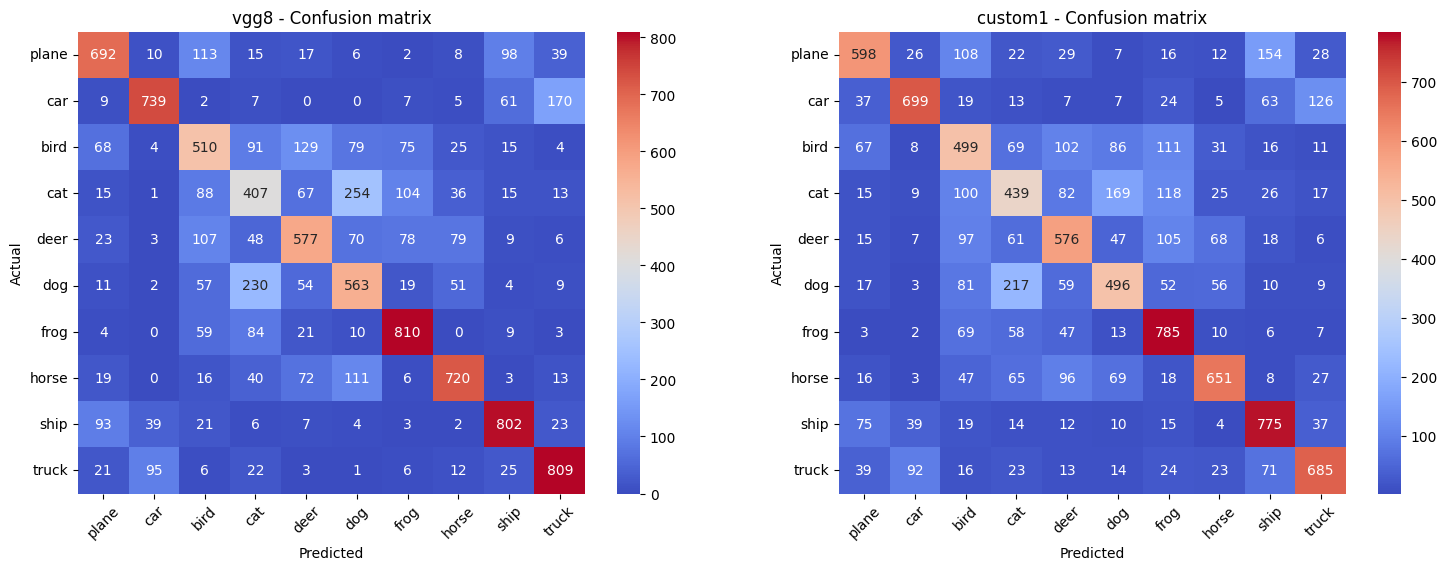

2022-08-09 12:45:21,796: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1


----------------------------------------sample analysis----------------------------------------


2022-08-09 12:45:22,834: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/default.generator
2022-08-09 12:45:22,841: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1
2022-08-09 12:45:23,724: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/default.generator
2022-08-09 12:45:23,729: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/mlp1
2022-08-09 12:45:24,042: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/default.generator
2022-08-09 12:45:24,044: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/

1/1 [==============================] - 0s 14ms/step


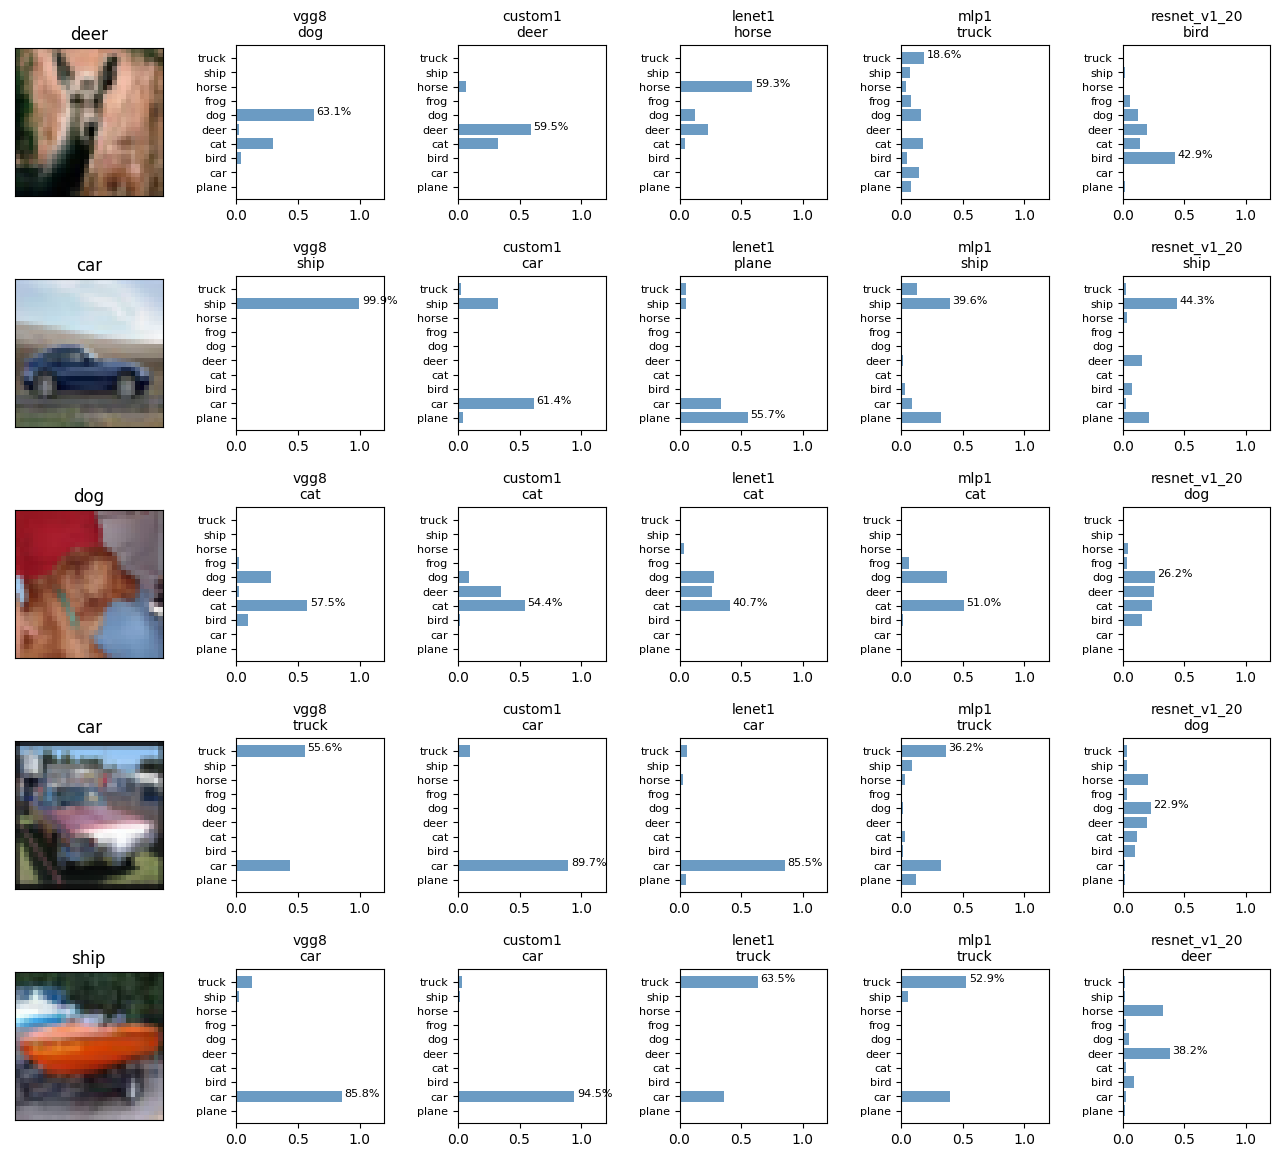

----------------------------------------models----------------------------------------


model_name                  program_name  weight_number  train_time  \
1          vgg8  cifar10_0808_count_500.ipynb        1672906       615.6   
2       custom1  cifar10_0808_count_500.ipynb          73738       286.2   
3        lenet1  cifar10_0808_count_500.ipynb          83170       265.6   
4          mlp1  cifar10_0808_count_500.ipynb         394634       128.5   
5  resnet_v1_20  cifar10_0808_count_500.ipynb         273066        18.6   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-09 12:45      0.4143     1.1857          0.8872         0.6629   
2  2022-08-09 12:34      0.1174     1.3468          0.9792         0.6203   
3  2022-08-09 12:29      0.2351     1.6441          0.9430         0.5212   
4  2022-08-09 12:24      1.3852     1.8163          0.5162         0.3729   
5  2022-08-09 12:18      2.3461     2.3815          0.2062         0.1980   

   train_auc  test_auc  
1     0.9910    0.9350  
2     0.9997    0.9283  
3     0.9979    0.8911  
4     0.8894    0.8013  
5     0.7818    0.7750

In [23]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.vgg1(helper, name='vgg8', dense_layer_count=1, block_count=3,)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### Resnet

参考https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)


2022-08-09 12:45:36,764: INFO: learning_rate=0.001
2022-08-09 12:45:36,765: INFO: model_params.resnet_v1_20.clip_value=None
2022-08-09 12:45:36,772: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20


Model: "resnet_v1_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 32, 32, 16)   448         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 32, 32, 16)  64          ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation (Activation)        (None, 32, 32, 16)   0           ['batch_normalization_

                                                                                                  
 batch_normalization_14 (BatchN  (None, 16, 16, 32)  128         ['conv2d_15[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_9 (Activation)      (None, 16, 16, 32)   0           ['batch_normalization_14[0][0]'] 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 16, 16, 32)   9248        ['activation_9[0][0]']           
                                                                                                  
 batch_normalization_15 (BatchN  (None, 16, 16, 32)  128         ['conv2d_16[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 activation_18 (Activation)     (None, 8, 8, 64)     0           ['add_8[0][0]']                  
                                                                                                  
 average_pooling2d (AveragePool  (None, 1, 1, 64)    0           ['activation_18[0][0]']          
 ing2D)                                                                                           
                                                                                                  
 flatten_4 (Flatten)            (None, 64)           0           ['average_pooling2d[0][0]']      
                                                                                                  
 dense_9 (Dense)                (None, 10)           650         ['flatten_4[0][0]']              
                                                                                                  
Total para

2022-08-09 12:45:36,895: INFO: model_params.resnet_v1_20.epochs=80
2022-08-09 12:45:36,896: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20, monitor=val_accuracy)
2022-08-09 12:45:36,896: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-09 12:45:36,897: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-09 12:45:36,898: INFO: use LearningRateScheduler()
2022-08-09 12:45:36,898: INFO: steps_per_epoch=156
2022-08-09 12:45:36,899: INFO: start training
2022-08-09 12:45:36,899: INFO: use_class_weight=False


Epoch 1/80
155/156 [============================>.] - ETA: 0s - loss: 2.1491 - accuracy: 0.2970

2022-08-09 12:45:53,689: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20/assets


2022-08-09 12:45:56,714: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20/assets


156/156 [==============================] - 20s 103ms/step - loss: 2.1477 - accuracy: 0.2977 - val_loss: 3.4175 - val_accuracy: 0.1334 - lr: 0.0010
Epoch 2/80
154/156 [============================>.] - ETA: 0s - loss: 1.6923 - accuracy: 0.4304

2022-08-09 12:46:09,545: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20/assets


2022-08-09 12:46:12,633: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20/assets


156/156 [==============================] - 16s 103ms/step - loss: 1.6933 - accuracy: 0.4303 - val_loss: 2.2268 - val_accuracy: 0.2749 - lr: 0.0010
Epoch 3/80
154/156 [============================>.] - ETA: 0s - loss: 1.4913 - accuracy: 0.5101

2022-08-09 12:46:25,205: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20/assets


2022-08-09 12:46:28,328: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20/assets


156/156 [==============================] - 16s 101ms/step - loss: 1.4927 - accuracy: 0.5092 - val_loss: 2.1921 - val_accuracy: 0.3164 - lr: 0.0010
Epoch 4/80
154/156 [============================>.] - ETA: 0s - loss: 1.3161 - accuracy: 0.5840

2022-08-09 12:46:41,608: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20/assets


2022-08-09 12:46:44,725: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20/assets


156/156 [==============================] - 16s 105ms/step - loss: 1.3176 - accuracy: 0.5833 - val_loss: 2.2730 - val_accuracy: 0.3320 - lr: 0.0010
Epoch 5/80
154/156 [============================>.] - ETA: 0s - loss: 1.1664 - accuracy: 0.6471

2022-08-09 12:46:57,241: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20/assets


2022-08-09 12:47:00,357: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20/assets


156/156 [==============================] - 16s 101ms/step - loss: 1.1668 - accuracy: 0.6468 - val_loss: 2.3028 - val_accuracy: 0.3636 - lr: 0.0010
Epoch 6/80
156/156 [==============================] - 5s 33ms/step - loss: 1.0319 - accuracy: 0.6917 - val_loss: 3.1001 - val_accuracy: 0.3453 - lr: 0.0010
Epoch 7/80
156/156 [==============================] - 5s 35ms/step - loss: 0.9199 - accuracy: 0.7416 - val_loss: 3.2265 - val_accuracy: 0.3485 - lr: 0.0010
Epoch 8/80
155/156 [============================>.] - ETA: 0s - loss: 0.8187 - accuracy: 0.7810

2022-08-09 12:47:23,224: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20/assets


2022-08-09 12:47:26,685: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20/assets


156/156 [==============================] - 16s 101ms/step - loss: 0.8183 - accuracy: 0.7806 - val_loss: 2.9583 - val_accuracy: 0.3694 - lr: 0.0010
Epoch 9/80
154/156 [============================>.] - ETA: 0s - loss: 0.7092 - accuracy: 0.8139

2022-08-09 12:47:39,141: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20/assets


2022-08-09 12:47:42,528: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20/assets


156/156 [==============================] - 16s 102ms/step - loss: 0.7100 - accuracy: 0.8131 - val_loss: 2.9361 - val_accuracy: 0.3741 - lr: 0.0010
Epoch 10/80
156/156 [==============================] - 5s 35ms/step - loss: 0.6223 - accuracy: 0.8480 - val_loss: 4.0064 - val_accuracy: 0.3154 - lr: 0.0010
Epoch 11/80
156/156 [==============================] - 5s 35ms/step - loss: 0.5743 - accuracy: 0.8644 - val_loss: 4.1203 - val_accuracy: 0.3235 - lr: 0.0010
Epoch 12/80
156/156 [==============================] - 5s 35ms/step - loss: 0.4976 - accuracy: 0.8976 - val_loss: 3.5817 - val_accuracy: 0.3520 - lr: 0.0010
Epoch 13/80
156/156 [==============================] - 5s 30ms/step - loss: 0.4254 - accuracy: 0.9265 - val_loss: 3.6388 - val_accuracy: 0.3212 - lr: 0.0010
Epoch 14/80
156/156 [==============================] - 5s 31ms/step - loss: 0.3903 - accuracy: 0.9393 - val_loss: 3.5004 - val_accuracy: 0.3493 - lr: 0.0010
Epoch 15/80
155/156 [============================>.] - ETA: 0s - los

2022-08-09 12:48:20,261: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20/assets


2022-08-09 12:48:23,998: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20/assets


156/156 [==============================] - 16s 100ms/step - loss: 0.3764 - accuracy: 0.9391 - val_loss: 3.3748 - val_accuracy: 0.3970 - lr: 0.0010
Epoch 16/80
154/156 [============================>.] - ETA: 0s - loss: 0.3439 - accuracy: 0.9539

2022-08-09 12:48:35,679: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20/assets


2022-08-09 12:48:39,294: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20/assets


156/156 [==============================] - 15s 98ms/step - loss: 0.3431 - accuracy: 0.9543 - val_loss: 3.4022 - val_accuracy: 0.4140 - lr: 0.0010
Epoch 17/80
156/156 [==============================] - 5s 30ms/step - loss: 0.2977 - accuracy: 0.9692 - val_loss: 6.0743 - val_accuracy: 0.2567 - lr: 0.0010
Epoch 18/80
153/156 [============================>.] - ETA: 0s - loss: 0.2700 - accuracy: 0.9818
Epoch 18: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
156/156 [==============================] - 5s 31ms/step - loss: 0.2698 - accuracy: 0.9820 - val_loss: 4.2171 - val_accuracy: 0.3663 - lr: 3.1623e-04
Epoch 00019: Still keep learning rate 0.0003162 instead of 0.001
Epoch 19/80
155/156 [============================>.] - ETA: 0s - loss: 0.2486 - accuracy: 0.9845

2022-08-09 12:49:00,028: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20/assets


2022-08-09 12:49:03,472: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20/assets


156/156 [==============================] - 15s 95ms/step - loss: 0.2484 - accuracy: 0.9846 - val_loss: 2.6554 - val_accuracy: 0.4976 - lr: 3.1623e-04
Epoch 00020: Still keep learning rate 0.0003162 instead of 0.001
Epoch 20/80
153/156 [============================>.] - ETA: 0s - loss: 0.2062 - accuracy: 0.9994

2022-08-09 12:49:14,538: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20/assets


2022-08-09 12:49:17,961: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20/assets


156/156 [==============================] - 15s 94ms/step - loss: 0.2062 - accuracy: 0.9994 - val_loss: 2.5406 - val_accuracy: 0.5009 - lr: 3.1623e-04
Epoch 00021: Still keep learning rate 0.0003162 instead of 0.001
Epoch 21/80
153/156 [============================>.] - ETA: 0s - loss: 0.1997 - accuracy: 1.0000

2022-08-09 12:49:29,500: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20/assets


2022-08-09 12:49:33,008: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20/assets


156/156 [==============================] - 15s 96ms/step - loss: 0.1997 - accuracy: 1.0000 - val_loss: 2.5083 - val_accuracy: 0.5054 - lr: 3.1623e-04
Epoch 00022: Still keep learning rate 0.0003162 instead of 0.001
Epoch 22/80
156/156 [==============================] - 5s 29ms/step - loss: 0.1976 - accuracy: 1.0000 - val_loss: 2.5222 - val_accuracy: 0.5033 - lr: 3.1623e-04
Epoch 00023: Still keep learning rate 0.0003162 instead of 0.001
Epoch 23/80
156/156 [==============================] - 5s 29ms/step - loss: 0.1959 - accuracy: 1.0000 - val_loss: 2.5369 - val_accuracy: 0.5036 - lr: 3.1623e-04
Epoch 00024: Still keep learning rate 0.0003162 instead of 0.001
Epoch 24/80
156/156 [==============================] - 5s 30ms/step - loss: 0.1944 - accuracy: 1.0000 - val_loss: 2.5500 - val_accuracy: 0.5046 - lr: 3.1623e-04
Epoch 00025: Still keep learning rate 0.0003162 instead of 0.001
Epoch 25/80
156/156 [==============================] - 5s 31ms/step - loss: 0.1928 - accuracy: 1.0000 - val

2022-08-09 12:50:17,772: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20/assets


2022-08-09 12:50:21,394: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20/assets


156/156 [==============================] - 15s 99ms/step - loss: 0.1861 - accuracy: 1.0000 - val_loss: 2.6005 - val_accuracy: 0.5056 - lr: 3.1623e-04
Epoch 00030: Still keep learning rate 0.0003162 instead of 0.001
Epoch 30/80
154/156 [============================>.] - ETA: 0s - loss: 0.1843 - accuracy: 1.0000

2022-08-09 12:50:33,008: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20/assets


2022-08-09 12:50:36,629: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20/assets


156/156 [==============================] - 15s 98ms/step - loss: 0.1843 - accuracy: 1.0000 - val_loss: 2.6087 - val_accuracy: 0.5061 - lr: 3.1623e-04
Epoch 00031: Still keep learning rate 0.0003162 instead of 0.001
Epoch 31/80
156/156 [==============================] - 5s 29ms/step - loss: 0.1823 - accuracy: 1.0000 - val_loss: 2.6165 - val_accuracy: 0.5057 - lr: 3.1623e-04
Epoch 00032: Still keep learning rate 0.0003162 instead of 0.001
Epoch 32/80
154/156 [============================>.] - ETA: 0s - loss: 0.1803 - accuracy: 1.0000

2022-08-09 12:50:52,521: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20/assets


2022-08-09 12:50:56,179: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20/assets


156/156 [==============================] - 15s 97ms/step - loss: 0.1803 - accuracy: 1.0000 - val_loss: 2.6238 - val_accuracy: 0.5062 - lr: 3.1623e-04
Epoch 00033: Still keep learning rate 0.0003162 instead of 0.001
Epoch 33/80
156/156 [==============================] - ETA: 0s - loss: 0.1782 - accuracy: 1.0000
Epoch 33: ReduceLROnPlateau reducing learning rate to 0.00010000000639606199.
156/156 [==============================] - 5s 30ms/step - loss: 0.1782 - accuracy: 1.0000 - val_loss: 2.6306 - val_accuracy: 0.5049 - lr: 1.0000e-04
Epoch 00034: Still keep learning rate 0.0001 instead of 0.001
Epoch 34/80
156/156 [==============================] - 5s 31ms/step - loss: 0.1767 - accuracy: 1.0000 - val_loss: 2.6546 - val_accuracy: 0.5055 - lr: 1.0000e-04
Epoch 00035: Still keep learning rate 0.0001 instead of 0.001
Epoch 35/80
156/156 [==============================] - 5s 32ms/step - loss: 0.1759 - accuracy: 1.0000 - val_loss: 2.6616 - val_accuracy: 0.5054 - lr: 1.0000e-04
Epoch 00036: St

2022-08-09 12:53:23,686: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20/assets


2022-08-09 12:53:27,349: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20/assets


156/156 [==============================] - 16s 100ms/step - loss: 0.7667 - accuracy: 0.7752 - val_loss: 1.5524 - val_accuracy: 0.5175 - lr: 1.0000e-04
Epoch 62/80
154/156 [============================>.] - ETA: 0s - loss: 0.6215 - accuracy: 0.8281

2022-08-09 12:53:39,203: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20/assets


2022-08-09 12:53:42,868: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20/assets


156/156 [==============================] - 15s 100ms/step - loss: 0.6228 - accuracy: 0.8277 - val_loss: 1.4751 - val_accuracy: 0.5410 - lr: 1.0000e-04
Epoch 63/80
154/156 [============================>.] - ETA: 0s - loss: 0.5342 - accuracy: 0.8659

2022-08-09 12:53:54,764: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20/assets


2022-08-09 12:53:58,397: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20/assets


156/156 [==============================] - 15s 100ms/step - loss: 0.5351 - accuracy: 0.8658 - val_loss: 1.5300 - val_accuracy: 0.5430 - lr: 1.0000e-04
Epoch 64/80
156/156 [==============================] - 5s 31ms/step - loss: 0.4564 - accuracy: 0.8978 - val_loss: 1.6192 - val_accuracy: 0.5372 - lr: 1.0000e-04
Epoch 65/80
156/156 [==============================] - 5s 29ms/step - loss: 0.3848 - accuracy: 0.9279 - val_loss: 1.7122 - val_accuracy: 0.5312 - lr: 1.0000e-04
Epoch 66/80
156/156 [==============================] - 5s 31ms/step - loss: 0.3221 - accuracy: 0.9537 - val_loss: 1.7988 - val_accuracy: 0.5299 - lr: 1.0000e-04
Epoch 67/80
156/156 [==============================] - 5s 31ms/step - loss: 0.2688 - accuracy: 0.9700 - val_loss: 1.8820 - val_accuracy: 0.5320 - lr: 1.0000e-04
Epoch 68/80
156/156 [==============================] - 5s 31ms/step - loss: 0.2243 - accuracy: 0.9840 - val_loss: 1.9667 - val_accuracy: 0.5311 - lr: 1.0000e-04
Epoch 69/80
156/156 [=======================

2022-08-09 12:55:20,258: INFO: finish training [elapsed time: 583.36 seconds]


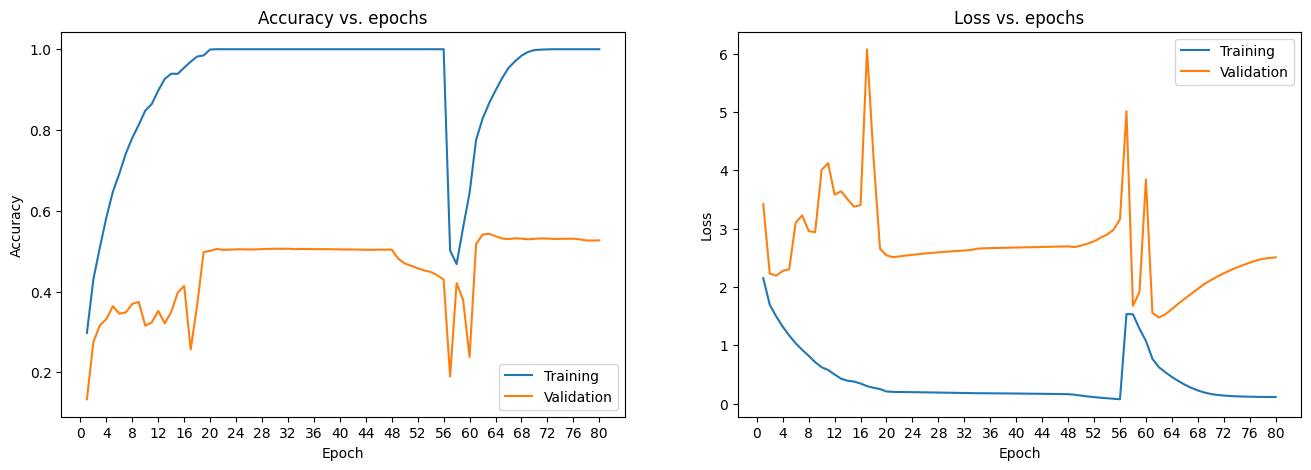

2022-08-09 12:55:20,745: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/resnet_v1_20
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 2s 6ms/step


2022-08-09 12:55:34,692: INFO: test loss:1.5300
2022-08-09 12:55:34,693: INFO: test accuracy:0.5430
2022-08-09 12:55:34,697: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/results.json
2022-08-09 12:55:34,699: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/results.json
2022-08-09 12:55:34,699: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/default.generator
2022-08-09 12:55:34,700: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/default.generator
2022-08-09 12:55:34,701: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vg

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-09 12:55:36,180: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/default.generator


313/313 [==============================] - 1s 3ms/step


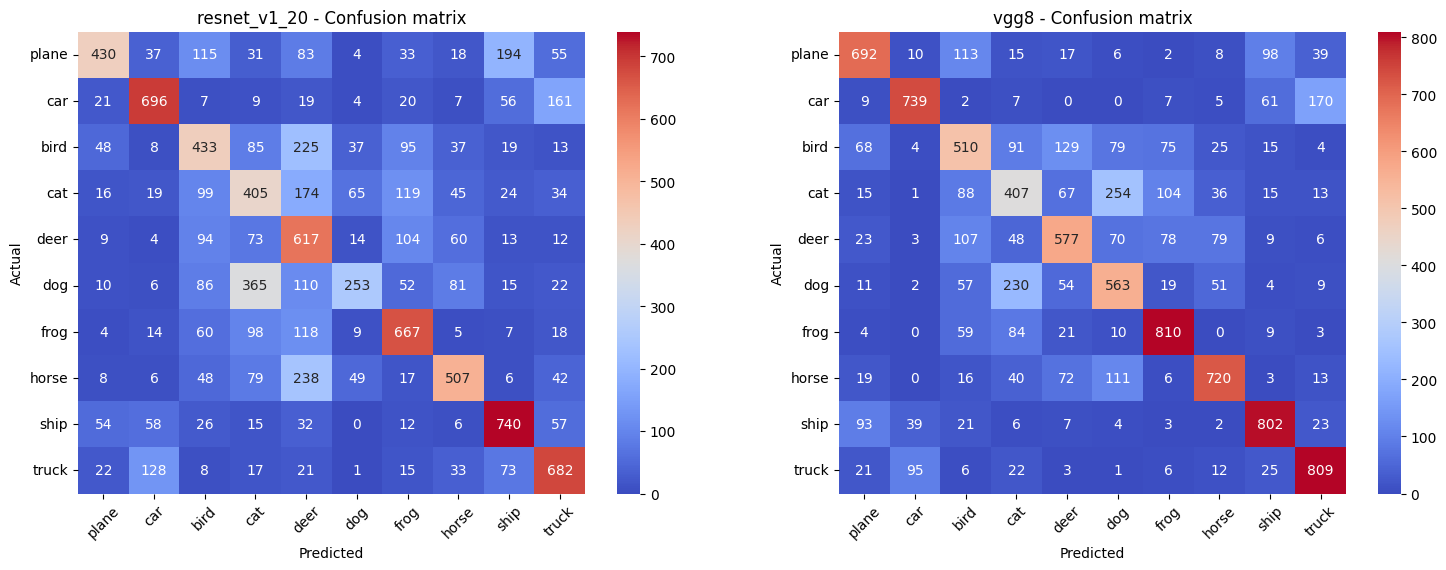

2022-08-09 12:55:43,430: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/vgg8


----------------------------------------sample analysis----------------------------------------


2022-08-09 12:55:45,049: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/default.generator
2022-08-09 12:55:45,056: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/custom1
2022-08-09 12:55:46,044: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/default.generator
2022-08-09 12:55:46,049: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/lenet1
2022-08-09 12:55:46,912: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_500/default.generator
2022-08-09 12:55:46,919: INFO: loading model from /tf/eipi10/xuxiangwen.github.

1/1 [==============================] - 0s 10ms/step


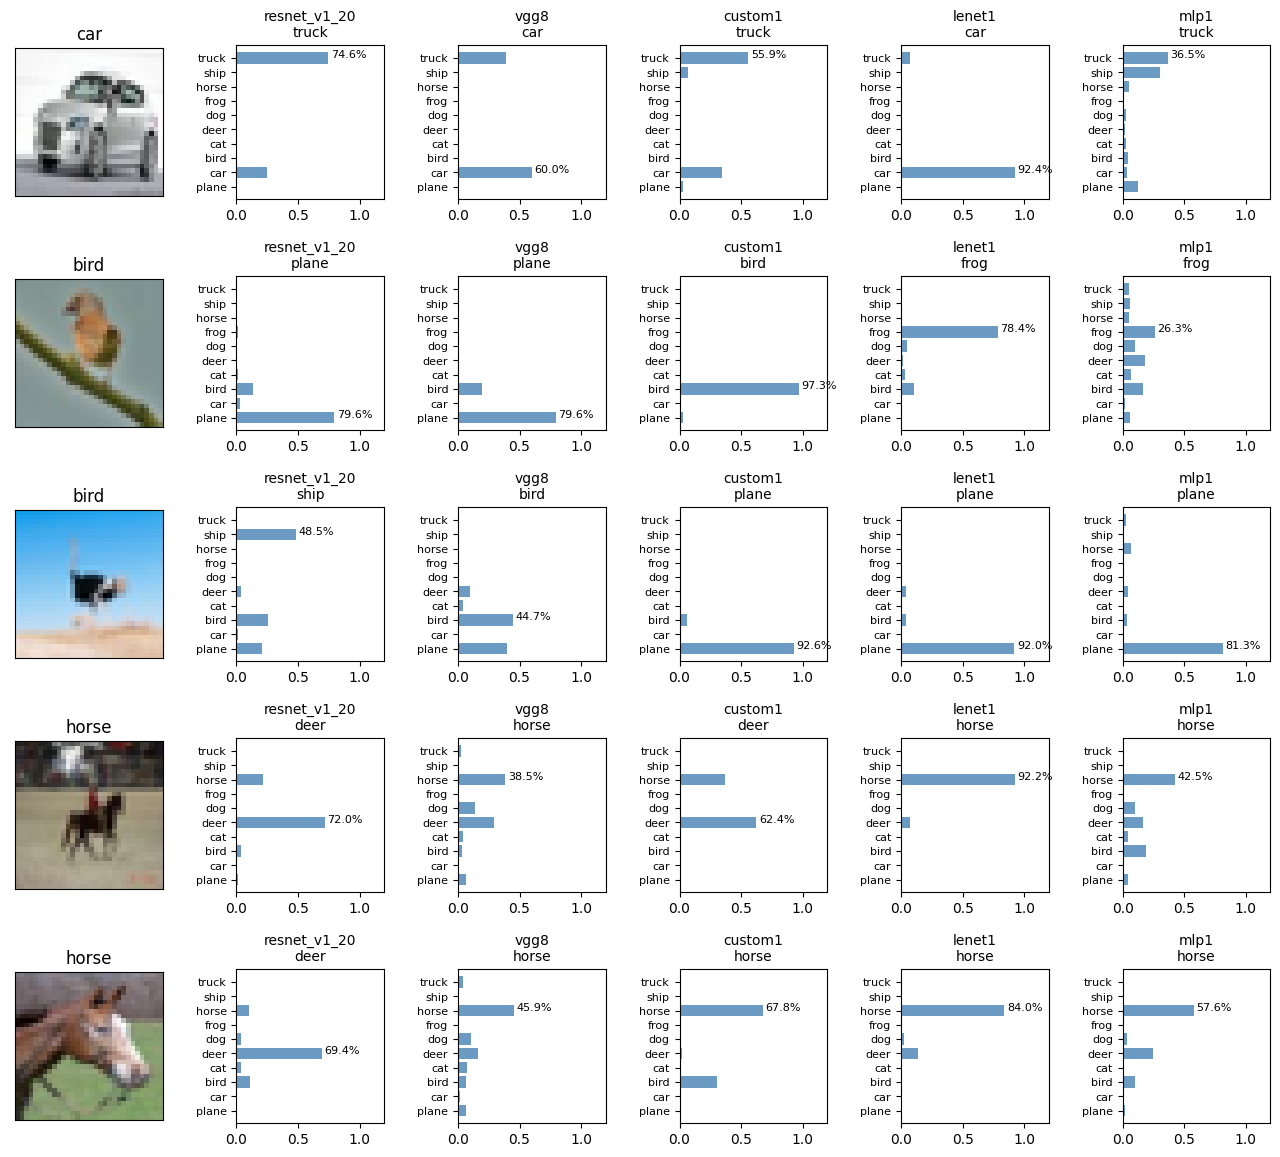

----------------------------------------models----------------------------------------


model_name                  program_name  weight_number  train_time  \
1          vgg8  cifar10_0808_count_500.ipynb        1672906       615.6   
2       custom1  cifar10_0808_count_500.ipynb          73738       286.2   
3  resnet_v1_20  cifar10_0808_count_500.ipynb         273066       583.4   
4        lenet1  cifar10_0808_count_500.ipynb          83170       265.6   
5          mlp1  cifar10_0808_count_500.ipynb         394634       128.5   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-09 12:45      0.4143     1.1857          0.8872         0.6629   
2  2022-08-09 12:34      0.1174     1.3468          0.9792         0.6203   
3  2022-08-09 12:55      0.5584     1.5300          0.8448         0.5430   
4  2022-08-09 12:29      0.2351     1.6441          0.9430         0.5212   
5  2022-08-09 12:24      1.3852     1.8163          0.5162         0.3729   

   train_auc  test_auc  
1     0.9910    0.9350  
2     0.9997    0.9283  
3     0.9901    0.9061  
4     0.9979    0.8911  
5     0.8894    0.8013

In [24]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.resnet_v1(helper, name='resnet_v1', depth=20)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

## 评估

### 最佳模型

In [25]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10)

2022-08-09 12:55:54,991: INFO: getting results for /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10
2022-08-09 12:55:54,993: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/results.json
2022-08-09 12:55:54,994: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/results.json
2022-08-09 12:55:54,995: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/results.json
2022-08-09 12:55:54,996: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/results.json
2022-08-09 12:55:54,997: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflo

model_name                   program_name  weight_number  train_time  \
1           vgg8        cifar10_0808_p100.ipynb        1672906      2759.0   
2           vgg8        cifar10_0721_p100.ipynb        1672906      2195.2   
3           vgg8  cifar10_0808_count_5000.ipynb        1672906      1973.9   
4           vgg8  cifar10_0808_count_2000.ipynb        1672906      1399.2   
5   resnet_v1_20        cifar10_0808_p100.ipynb         273066      3631.9   
6   resnet_v1_20  cifar10_0808_count_5000.ipynb         273066      2984.0   
7   resnet_v1_20        cifar10_0721_p100.ipynb         273066      4091.3   
8        custom1        cifar10_0808_p100.ipynb          73738       849.4   
9        custom1  cifar10_0808_count_5000.ipynb          73738       836.9   
10       custom1        cifar10_0721_p100.ipynb          73738      1190.8   

         create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1   2022-08-09 10:18      0.0017     0.5896          0.9997         0.8968   
2   2021-12-02 08:49      0.0029     0.5959          0.9995         0.8921   
3   2022-08-09 07:07      0.0044     0.5588          0.9991         0.8873   
4   2022-08-09 10:22      0.0064     0.8481          0.9987         0.8418   
5   2022-08-09 11:19      0.1058     1.3800          0.9979         0.8262   
6   2022-08-09 07:58      0.2096     1.1902          0.9986         0.8252   
7   2021-12-02 09:58      0.1180     1.3054          0.9985         0.8197   
8   2022-08-09 09:31      0.3383     0.5942          0.8858         0.8009   
9   2022-08-09 06:34      0.3235     0.6073          0.8893         0.7981   
10  2021-12-02 08:12      0.3420     0.6094          0.8832         0.7947   

    train_auc  test_auc  
1      1.0000    0.9922  
2      1.0000    0.9920  
3      1.0000    0.9919  
4      1.0000    0.9838  
5      1.0000    0.9796  
6      1.0000    0.9810  
7      1.0000    0.9791  
8      0.9926    0.9778  
9      0.9934    0.9776  
10     0.9929    0.9776

In [26]:

predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

2022-08-09 12:55:55,083: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8
2022-08-09 12:55:56,716: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/default.generator
2022-08-09 12:55:56,722: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8
2022-08-09 12:55:58,405: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator
2022-08-09 12:55:58,411: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8
2022-08-09 12:56:00,409: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_c

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


None

1/1 [==============================] - 0s 14ms/step


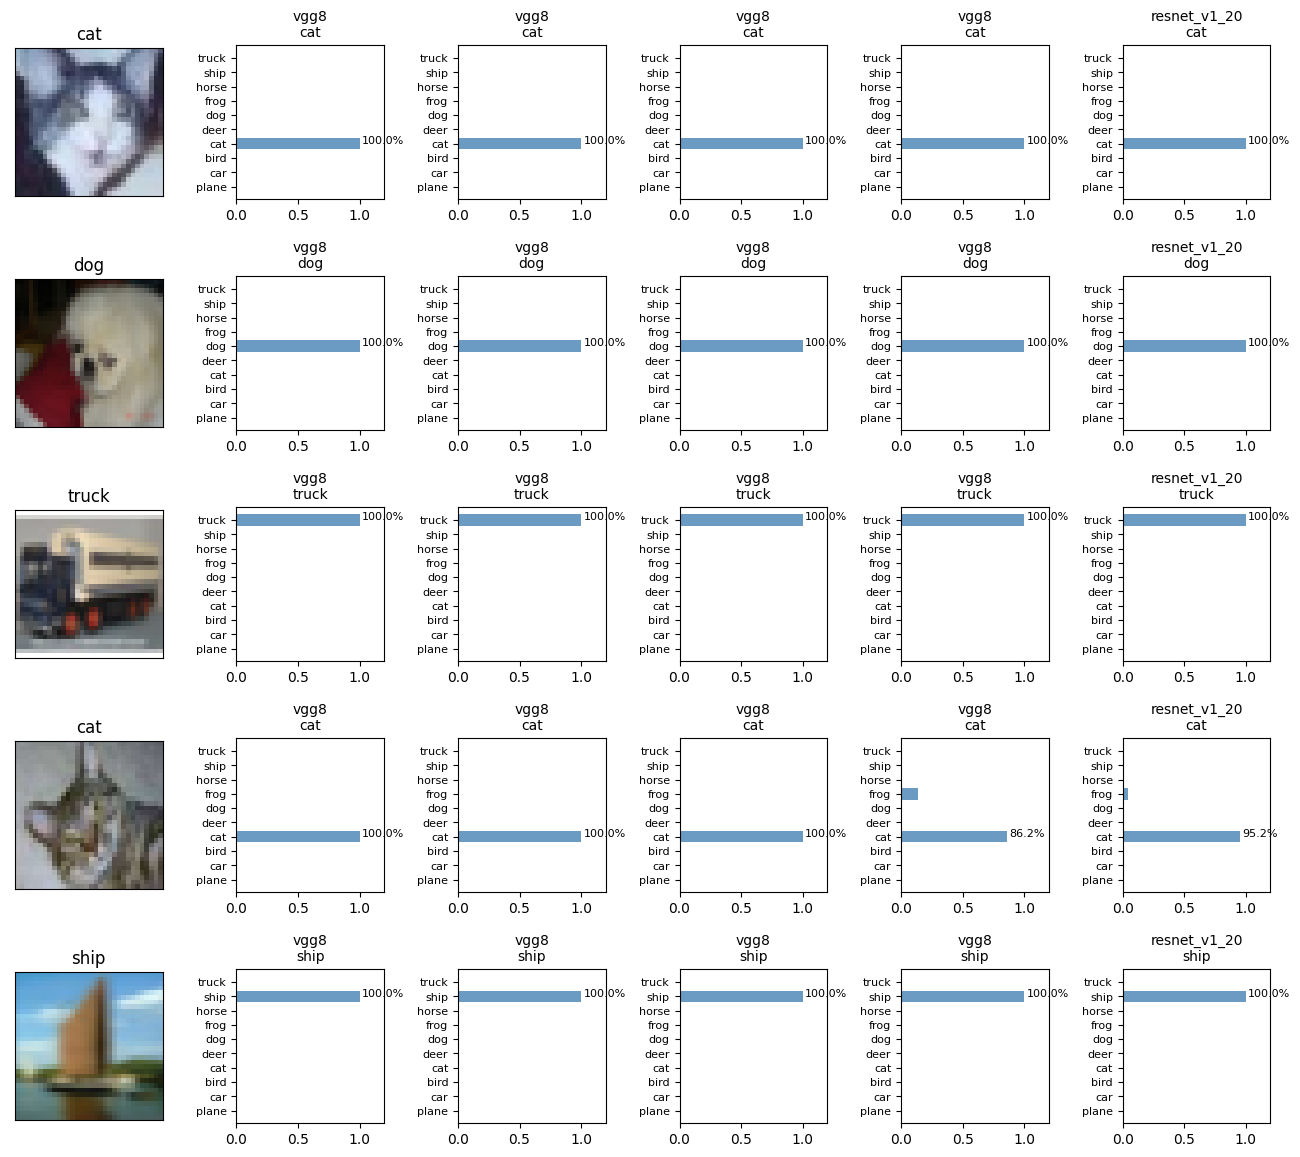

In [27]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=False) 

1/1 [==============================] - 0s 16ms/step


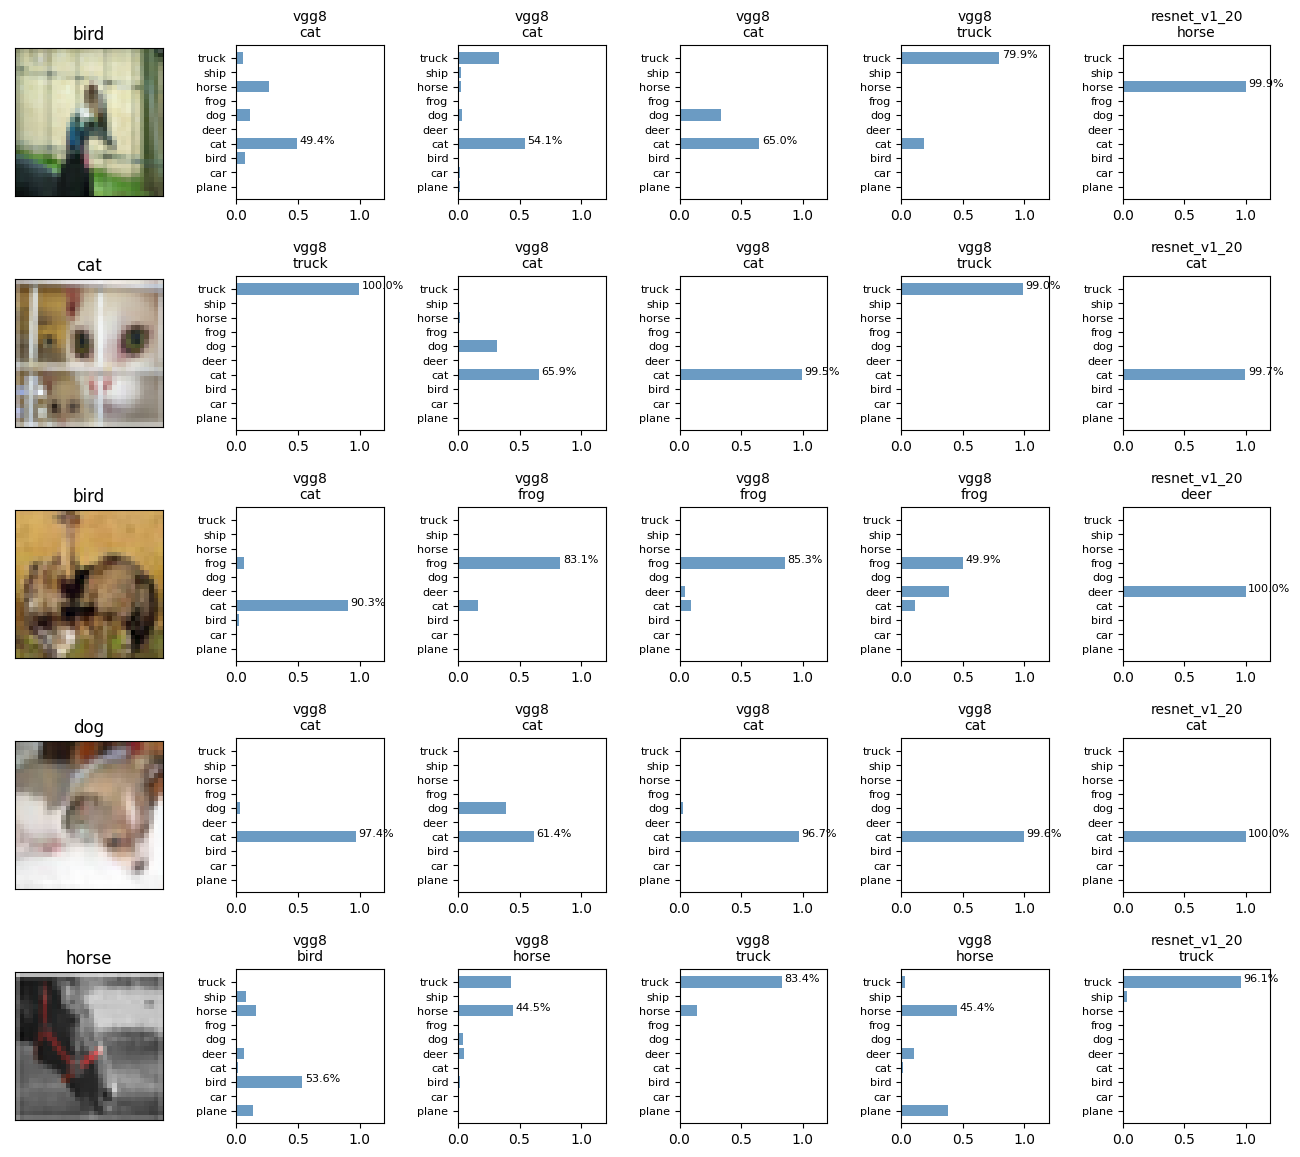

In [28]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=True) 

### 评估

In [29]:
results = best_predictor.evaluate(test_images, test_labels)
print(results)

predictions = best_predictor.predict(test_images)
print(predictions.shape)

{'loss': 0.5896327495574951, 'accuracy': 0.8967999815940857, 'mae': 25.367116928100586}
313/313 [==============================] - 1s 4ms/step
(10000, 10)


In [30]:
top1_predictions = best_predictor.predict_top_k(test_images, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

313/313 [==============================] - 1s 4ms/step


precision  recall        f1
plane   0.904245   0.916  0.910084
car     0.944334   0.950  0.947159
bird    0.872802   0.844  0.858160
cat     0.819549   0.763  0.790264
deer    0.889655   0.903  0.896278
dog     0.824832   0.857  0.840608
frog    0.897901   0.941  0.918945
horse   0.941358   0.915  0.927992
ship    0.943775   0.940  0.941884
truck   0.926950   0.939  0.932936

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

       plane     0.9042    0.9160    0.9101      1000
         car     0.9443    0.9500    0.9472      1000
        bird     0.8728    0.8440    0.8582      1000
         cat     0.8195    0.7630    0.7903      1000
        deer     0.8897    0.9030    0.8963      1000
         dog     0.8248    0.8570    0.8406      1000
        frog     0.8979    0.9410    0.9189      1000
       horse     0.9414    0.9150    0.9280      1000
        ship     0.9438    0.9400    0.9419      1000
       truck     0.9269    0.9390    0.9329      1000

    accuracy                         0.8968     10000
   macro avg     0.8965    0.8968    0.8964     10000
weighted avg     0.8965    0.8968    0.8964     10000



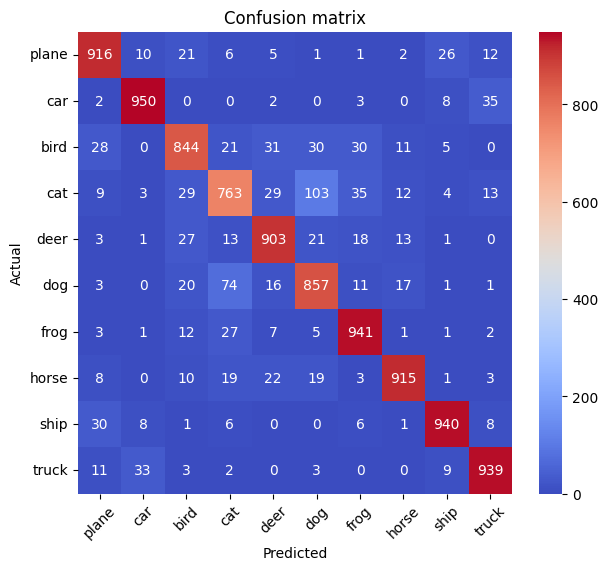

In [31]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## 参考

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)

In [32]:
type(helper.datasets.train_dataset)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset